In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_climate_change_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    cast_to_float,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = (
    load_climate_change_data()
    .pipe(format_datetime, col="Date Time")
    .pipe(set_index, col="Date Time")
    .pipe(interpolate_column)
    .pipe(resample_Data, freq="D")
    .pipe(replace_null)
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (420551, 15)
set_index: DF Shape (420551, 14)
interpolate_columns: DF Shape (420551, 14)
resample_Data: DF Shape (2923, 14)
replace_null: DF Shape (2923, 14)
dataframe shape (2923, 14)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: D
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         2923 non-null   float64
 1   T (degC)         2923 non-null   float64
 2   Tpot (K)         2923 non-null   float64
 3   Tdew (degC)      2923 non-null   float64
 4   rh (%)           2923 non-null   float64
 5   VPmax (mbar)     2923 non-null   float64
 6   VPact (mbar)     2923 non-null   float64
 7   VPdef (mbar)     2923 non-null   float64
 8   sh (g/kg)        2923 non-null   float64
 9   H2OC (mmol/mol)  2923 non-null   float64
 10  rho (g/m**3)     2923 non-null   float64
 11  wv (m/s)         2923 non-null   float64
 12  max. wv

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01,999.145594,-6.810629,266.414545,-8.015594,91.086014,3.691119,3.355524,0.335315,2.091049,3.357832,1305.178252,0.778601,1.378252,181.863077
2009-01-02,985.760694,-3.360486,270.909167,-5.751597,83.506944,4.766875,3.975486,0.790833,2.512500,4.033611,1270.863125,3.938819,6.171736,44.648750
2009-01-03,984.868264,5.435694,279.814097,3.269583,86.875764,9.143681,7.744792,1.397639,4.906389,7.863819,1227.955833,2.233819,3.427778,173.602083
2009-01-04,993.855069,7.283889,280.939167,-0.283611,61.858472,10.779028,6.000764,4.778264,3.764097,6.037569,1232.163125,2.840764,4.713125,80.935417
2009-01-05,994.080972,12.690069,286.335833,9.444444,81.556806,15.005556,11.882778,3.123056,7.469097,11.953056,1206.159792,1.567778,2.772639,139.180625


In [4]:
dataframe.isna().sum()

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

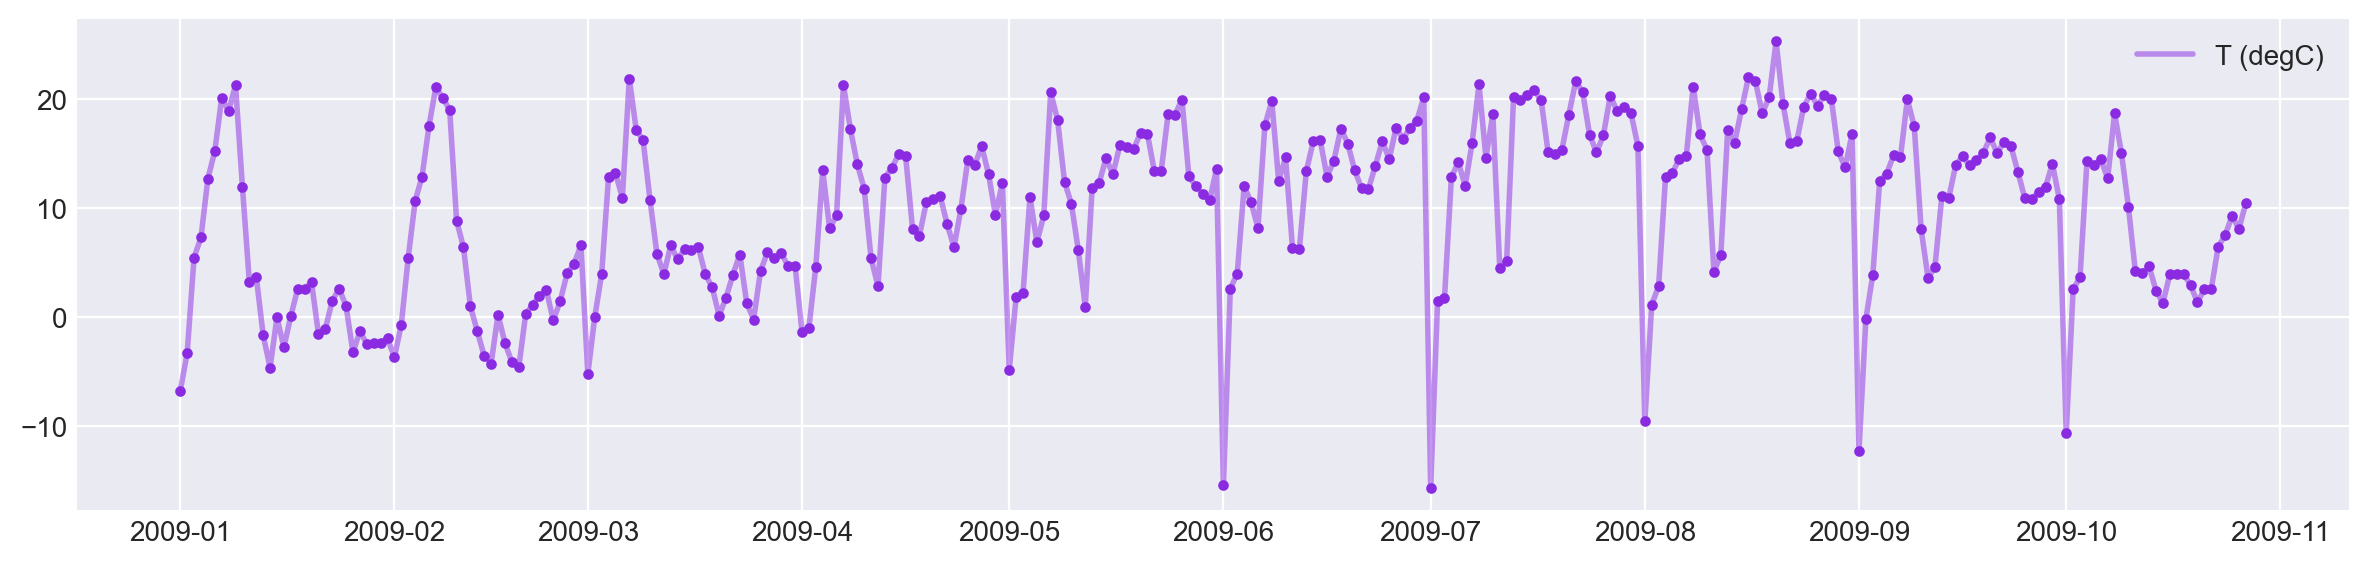

In [5]:
show_dataset(dataframe[:300], columns=["T (degC)"])

In [6]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "T (degC)"
TEST_SIZE = 30

In [7]:
train_data, test_data = test_train_split(dataframe, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)

train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

print(f"train_data shape after Feature Union {train_data_feat.shape}")
print(f"test_data shape after Feature Union {test_data_feat.shape}")

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data shape after Null Removal {train_data_feat.shape}")
print(f"test_data shape after Null Removal {test_data_feat.shape}")

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

test_data_feat.head()

Train Size after Test_Train Split: (2893, 14)
Test  Size after Test_Train Split: (30, 14) 
train_data shape after Feature Union (2893, 33)
test_data shape after Feature Union (30, 33)
train_data shape after Null Removal (2891, 33)
test_data shape after Null Removal (30, 33)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
Date Time,,,,,,,,,,,,,,,,,,,,,
2016-12-03,1003.414861,1.385139,274.277847,0.160417,91.541667,6.754861,6.185833,0.568472,3.843681,6.164931,...,3.0,48.0,1.0,0.0,0.141120,-0.989992,-0.536573,0.843854,-0.961389,0.275192
2016-12-04,984.365486,9.739444,284.178194,6.018542,79.604097,12.577083,9.431389,3.145139,5.982292,9.582361,...,4.0,48.0,1.0,0.0,-0.756802,-0.653644,-0.536573,0.843854,-0.287874,0.957668
2016-12-05,974.827500,16.687500,291.969583,9.388056,63.751528,19.360347,11.842500,7.517083,7.592431,12.149931,...,5.0,49.0,0.0,1.0,-0.958924,0.283662,-0.536573,0.843854,0.650311,0.759668
2016-12-06,981.777639,16.083958,290.769375,12.605417,80.550208,18.443056,14.654306,3.787986,9.337917,14.928056,...,6.0,49.0,0.0,1.0,-0.279415,0.960170,-0.536573,0.843854,0.990603,-0.136767
2016-12-07,985.962708,20.098125,294.446528,11.862708,59.502847,23.658333,13.921528,9.736667,8.829583,14.119653,...,7.0,49.0,0.0,1.0,0.656987,0.753902,-0.536573,0.843854,0.420140,-0.907459


In [8]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.880 total time=   0.1s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.911 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.911 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.895 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.929 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.924 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.917 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.941 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.936 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.924 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.946 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

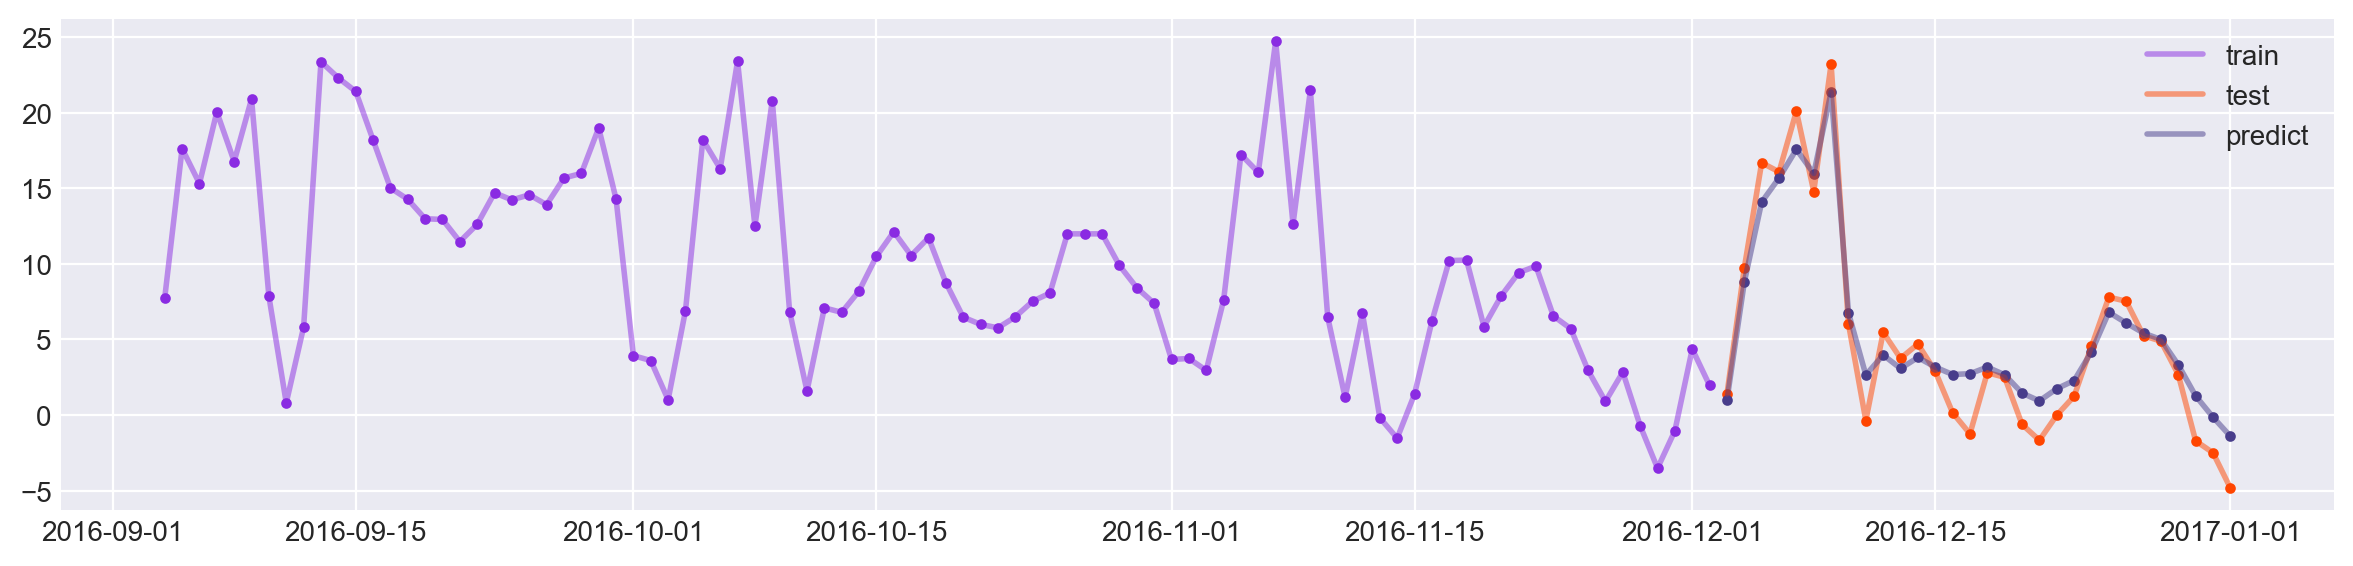

In [10]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [11]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  5  iterations


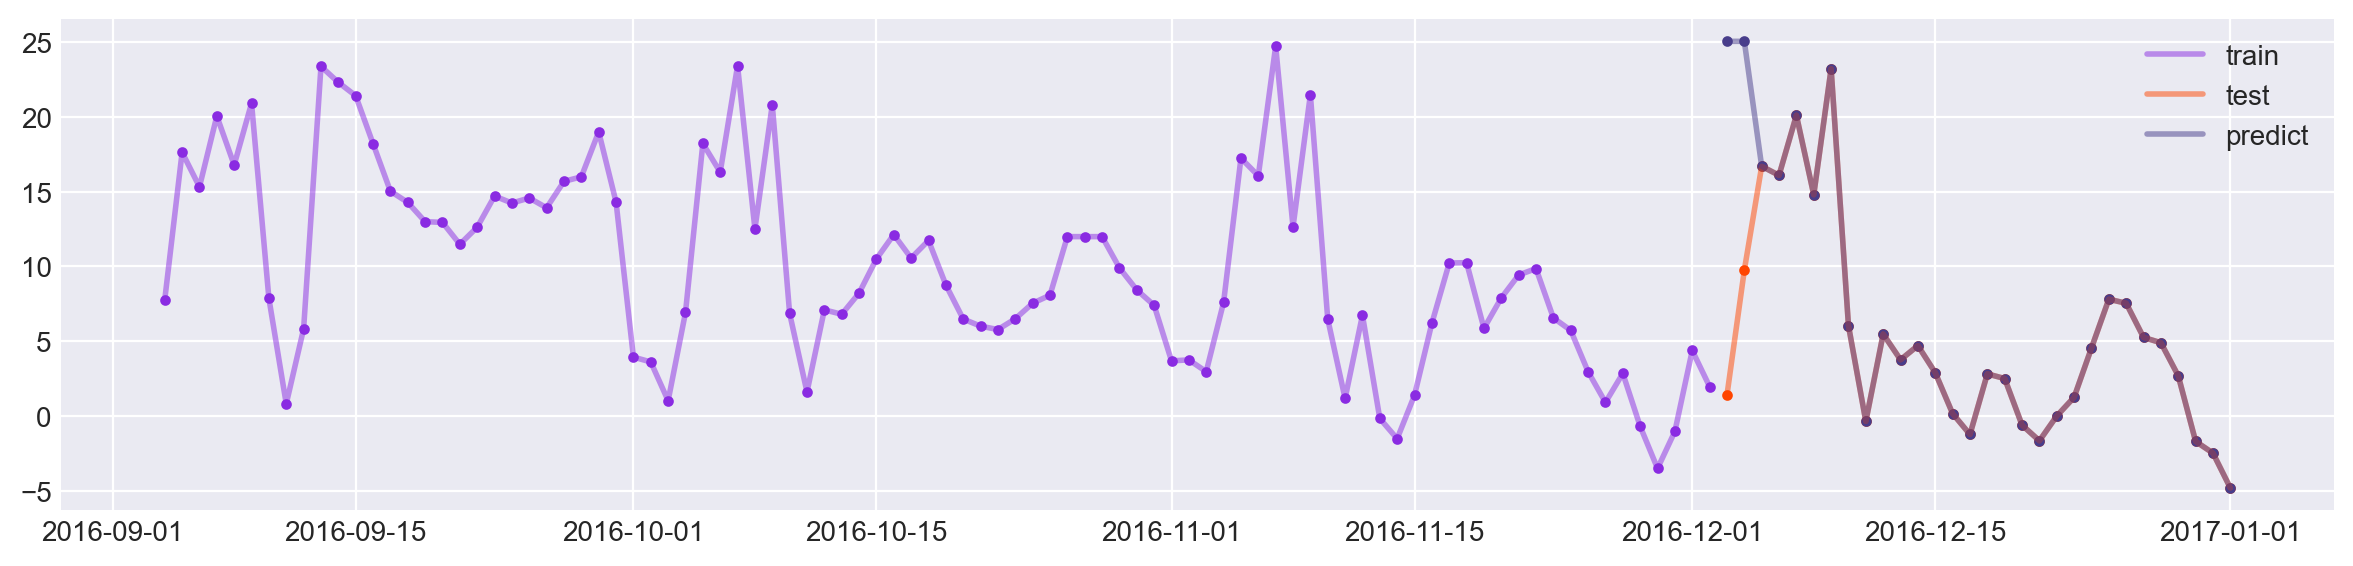

In [12]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [13]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

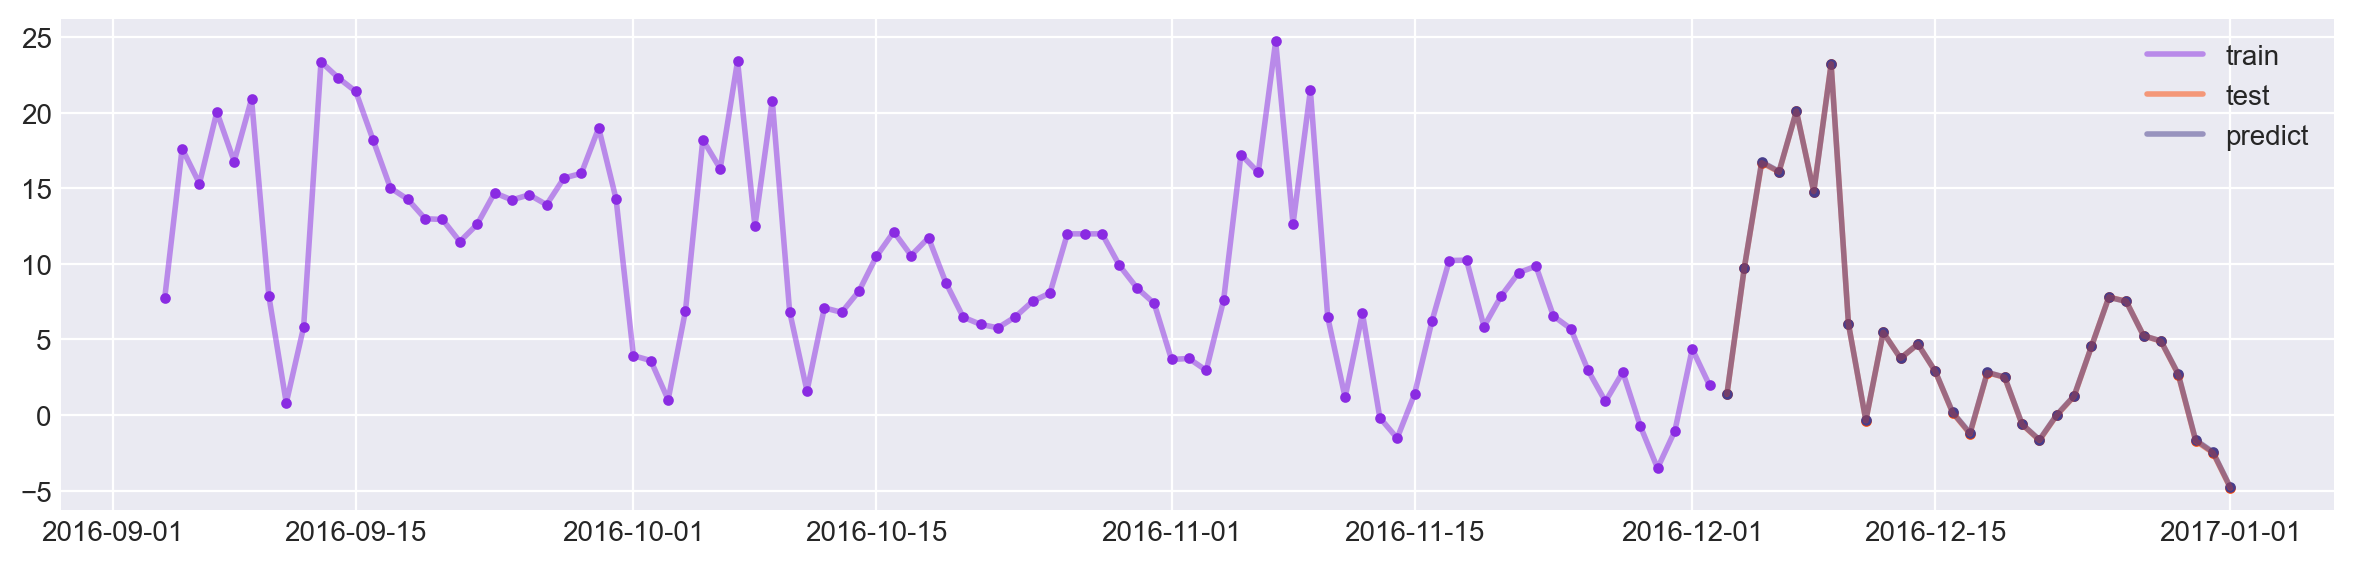

In [14]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# Best Params {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 600}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.999 total time=  12.4s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.999 total time=  27.8s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=600;, score=0.999 total time=  43.5s
0.9989379380478631 {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 600}


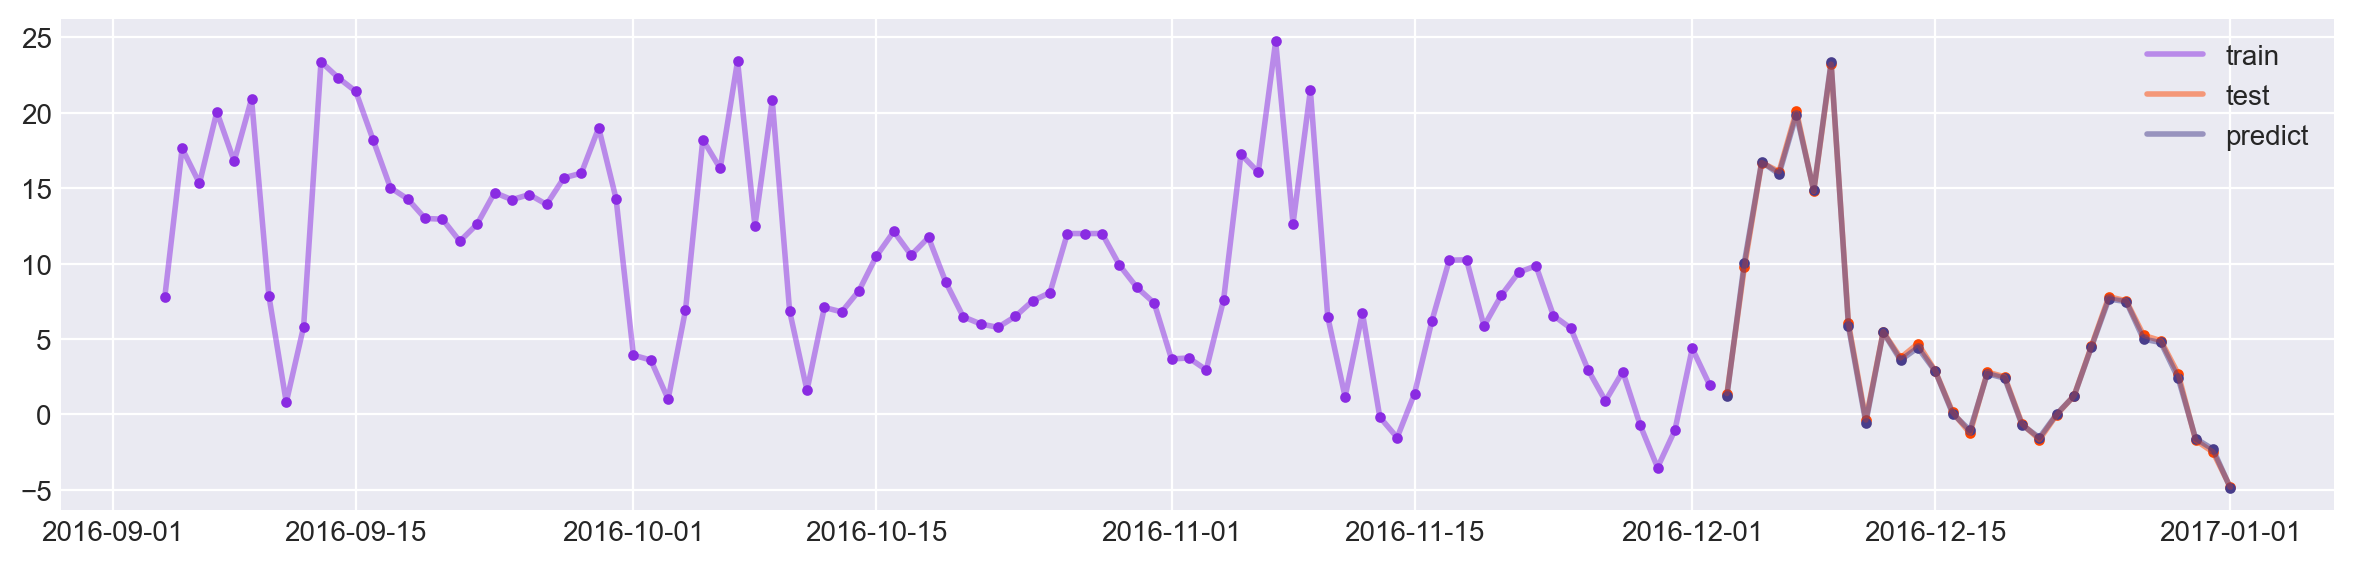

In [16]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:9.93554	validation_1-mae:5.63668
[1]	validation_0-mae:9.83687	validation_1-mae:5.58045
[2]	validation_0-mae:9.73923	validation_1-mae:5.52472
[3]	validation_0-mae:9.64251	validation_1-mae:5.47131
[4]	validation_0-mae:9.54675	validation_1-mae:5.41706
[5]	validation_0-mae:9.45199	validation_1-mae:5.36382
[6]	validation_0-mae:9.35816	validation_1-mae:5.31126
[7]	validation_0-mae:9.26527	validation_1-mae:5.25991
[8]	validation_0-mae:9.17331	validation_1-mae:5.20737
[9]	validation_0-mae:9.08224	validation_1-mae:5.15645
[10]	validation_0-mae:8.99212	validation_1-mae:5.10589
[11]	validation_0-mae:8.90290	validation_1-mae:5.05512
[12]	validation_0-mae:8.81452	validation_1-mae:5.00620
[13]	validation_0-mae:8.72704	validation_1-mae:4.95707
[14]	validation_0-mae:8.64046	validation_1-mae:4.90864
[15]	validation_0-mae:8.55468	validation_1-mae:4.86161
[16]	validation_0-mae:8.46980	validation_1-mae:4.81415
[17]	validation_0-mae:8.38571	validation_1-mae:4.76797
[18]	validation_0-ma

[149]	validation_0-mae:2.25043	validation_1-mae:1.32815
[150]	validation_0-mae:2.22817	validation_1-mae:1.31569
[151]	validation_0-mae:2.20614	validation_1-mae:1.30312
[152]	validation_0-mae:2.18432	validation_1-mae:1.29109
[153]	validation_0-mae:2.16273	validation_1-mae:1.27883
[154]	validation_0-mae:2.14135	validation_1-mae:1.26693
[155]	validation_0-mae:2.12020	validation_1-mae:1.25513
[156]	validation_0-mae:2.09923	validation_1-mae:1.24355
[157]	validation_0-mae:2.07849	validation_1-mae:1.23173
[158]	validation_0-mae:2.05794	validation_1-mae:1.22000
[159]	validation_0-mae:2.03760	validation_1-mae:1.20818
[160]	validation_0-mae:2.01746	validation_1-mae:1.19689
[161]	validation_0-mae:1.99753	validation_1-mae:1.18574
[162]	validation_0-mae:1.97778	validation_1-mae:1.17457
[163]	validation_0-mae:1.95824	validation_1-mae:1.16324
[164]	validation_0-mae:1.93888	validation_1-mae:1.15209
[165]	validation_0-mae:1.91971	validation_1-mae:1.14118
[166]	validation_0-mae:1.90073	validation_1-mae:

[296]	validation_0-mae:0.53009	validation_1-mae:0.34620
[297]	validation_0-mae:0.52502	validation_1-mae:0.34357
[298]	validation_0-mae:0.52000	validation_1-mae:0.34091
[299]	validation_0-mae:0.51506	validation_1-mae:0.33842
[300]	validation_0-mae:0.51014	validation_1-mae:0.33588
[301]	validation_0-mae:0.50529	validation_1-mae:0.33302
[302]	validation_0-mae:0.50047	validation_1-mae:0.33049
[303]	validation_0-mae:0.49572	validation_1-mae:0.32809
[304]	validation_0-mae:0.49102	validation_1-mae:0.32568
[305]	validation_0-mae:0.48635	validation_1-mae:0.32322
[306]	validation_0-mae:0.48175	validation_1-mae:0.32044
[307]	validation_0-mae:0.47718	validation_1-mae:0.31805
[308]	validation_0-mae:0.47267	validation_1-mae:0.31559
[309]	validation_0-mae:0.46819	validation_1-mae:0.31339
[310]	validation_0-mae:0.46376	validation_1-mae:0.31102
[311]	validation_0-mae:0.45936	validation_1-mae:0.30901
[312]	validation_0-mae:0.45500	validation_1-mae:0.30674
[313]	validation_0-mae:0.45071	validation_1-mae:

[443]	validation_0-mae:0.14824	validation_1-mae:0.14733
[444]	validation_0-mae:0.14722	validation_1-mae:0.14676
[445]	validation_0-mae:0.14621	validation_1-mae:0.14625
[446]	validation_0-mae:0.14518	validation_1-mae:0.14585
[447]	validation_0-mae:0.14419	validation_1-mae:0.14534
[448]	validation_0-mae:0.14320	validation_1-mae:0.14475
[449]	validation_0-mae:0.14222	validation_1-mae:0.14421
[450]	validation_0-mae:0.14125	validation_1-mae:0.14369
[451]	validation_0-mae:0.14032	validation_1-mae:0.14319
[452]	validation_0-mae:0.13939	validation_1-mae:0.14269
[453]	validation_0-mae:0.13846	validation_1-mae:0.14202
[454]	validation_0-mae:0.13752	validation_1-mae:0.14155
[455]	validation_0-mae:0.13662	validation_1-mae:0.14110
[456]	validation_0-mae:0.13573	validation_1-mae:0.14063
[457]	validation_0-mae:0.13485	validation_1-mae:0.14009
[458]	validation_0-mae:0.13395	validation_1-mae:0.13950
[459]	validation_0-mae:0.13309	validation_1-mae:0.13912
[460]	validation_0-mae:0.13224	validation_1-mae:

[589]	validation_0-mae:0.07623	validation_1-mae:0.11142
[590]	validation_0-mae:0.07605	validation_1-mae:0.11141
[591]	validation_0-mae:0.07586	validation_1-mae:0.11141
[592]	validation_0-mae:0.07568	validation_1-mae:0.11129
[593]	validation_0-mae:0.07551	validation_1-mae:0.11127
[594]	validation_0-mae:0.07535	validation_1-mae:0.11122
[595]	validation_0-mae:0.07518	validation_1-mae:0.11122
[596]	validation_0-mae:0.07500	validation_1-mae:0.11119
[597]	validation_0-mae:0.07483	validation_1-mae:0.11118
[598]	validation_0-mae:0.07467	validation_1-mae:0.11107
[599]	validation_0-mae:0.07451	validation_1-mae:0.11107
[600]	validation_0-mae:0.07434	validation_1-mae:0.11108
[601]	validation_0-mae:0.07417	validation_1-mae:0.11090
[602]	validation_0-mae:0.07402	validation_1-mae:0.11082
[603]	validation_0-mae:0.07387	validation_1-mae:0.11078
[604]	validation_0-mae:0.07372	validation_1-mae:0.11076
[605]	validation_0-mae:0.07357	validation_1-mae:0.11072
[606]	validation_0-mae:0.07342	validation_1-mae:

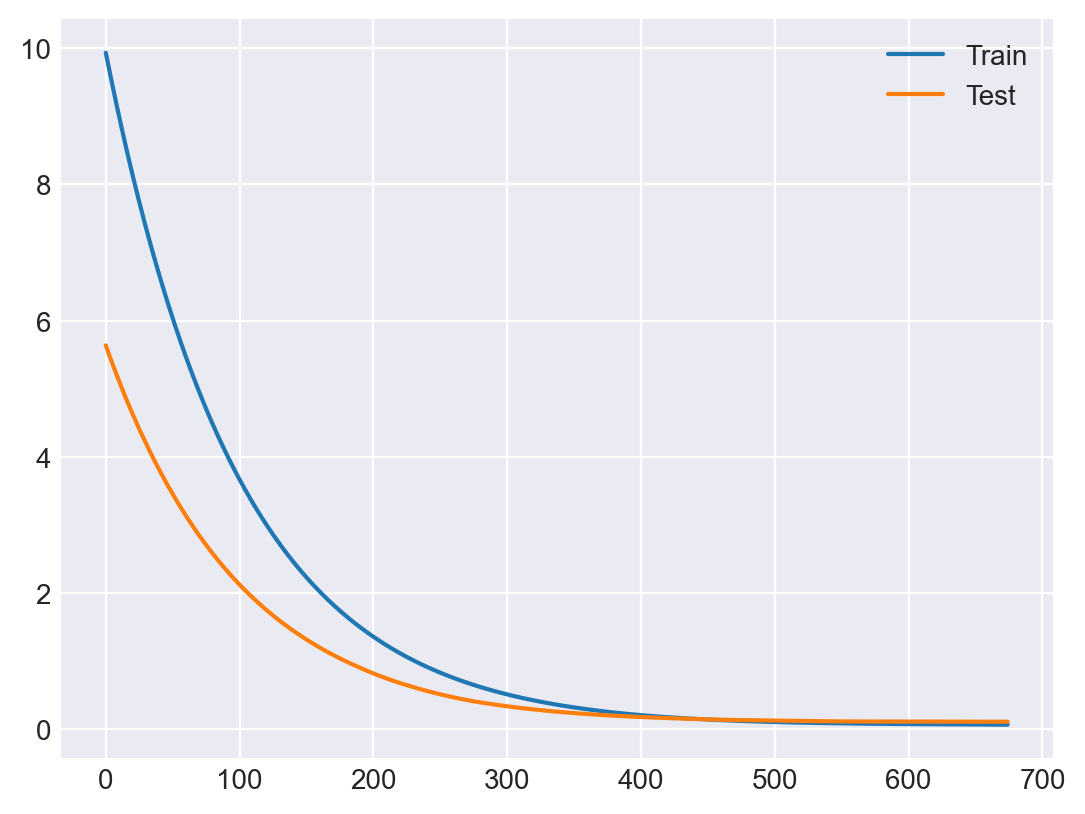

In [17]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

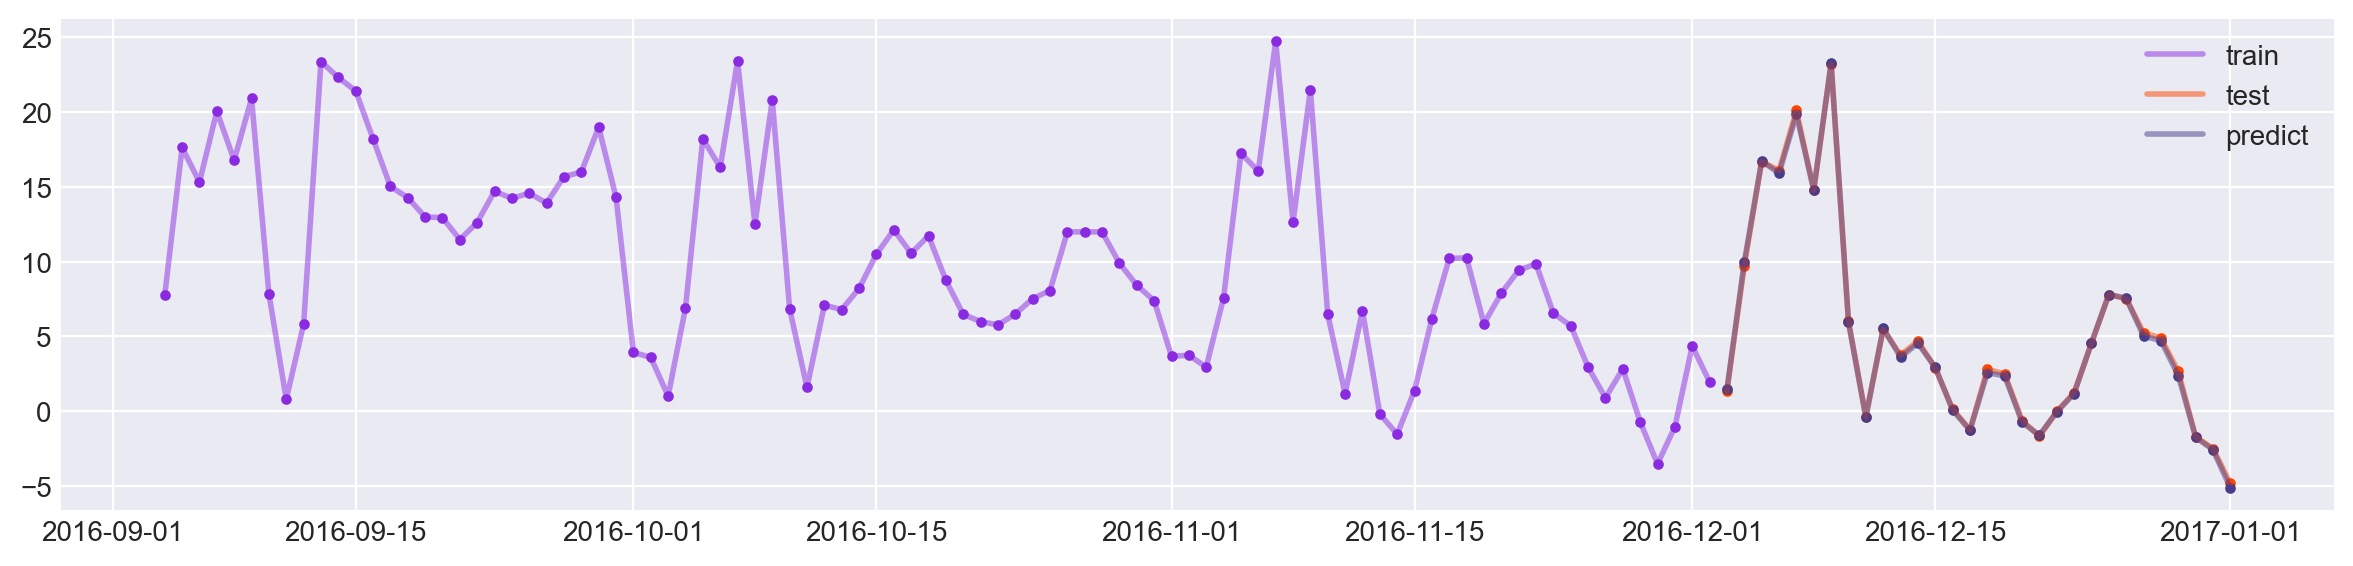

In [18]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [19]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 5.8433	training's l2: 49.6572	valid_1's l1: 6.62517	valid_1's l2: 53.6736
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 5.25991	training's l2: 40.2604	valid_1's l1: 5.95758	valid_1's l2: 43.4417
[3]	training's l1: 4.73522	training's l2: 32.6395	valid_1's l1: 5.35823	valid_1's l2: 35.2238
[4]	training's l1: 4.26304	training's l2: 26.4654	valid_1's l1: 4.82319	valid_1's l2: 28.6227
[5]	training's l1: 3.83789	training's l2: 21.4642	valid_1's l1: 4.33877	valid_1's l2: 23.2029
[6]	training's l1: 3.45555	training's l2: 17.409	valid_1's l1: 3.89986	valid_1's l2: 18.7907
[7]	training's l1: 3.1113	training's l2: 14.123	valid_1's l1: 3.50637	valid_1's l2: 15.2043
[8]	training's l1: 2.80145	training's l2: 11.4599	valid_1's l1: 3.15247	valid_1's l2: 12.2918
[9]	training's l1: 2.52287	training's l2: 9.30145	valid_1's l1: 2.83676	valid_1's l2: 9.97745
[10]	training's l1: 2.27204	training's l2: 7.55226	valid_1's l1: 2.54954	valid_1's l2: 8.07775


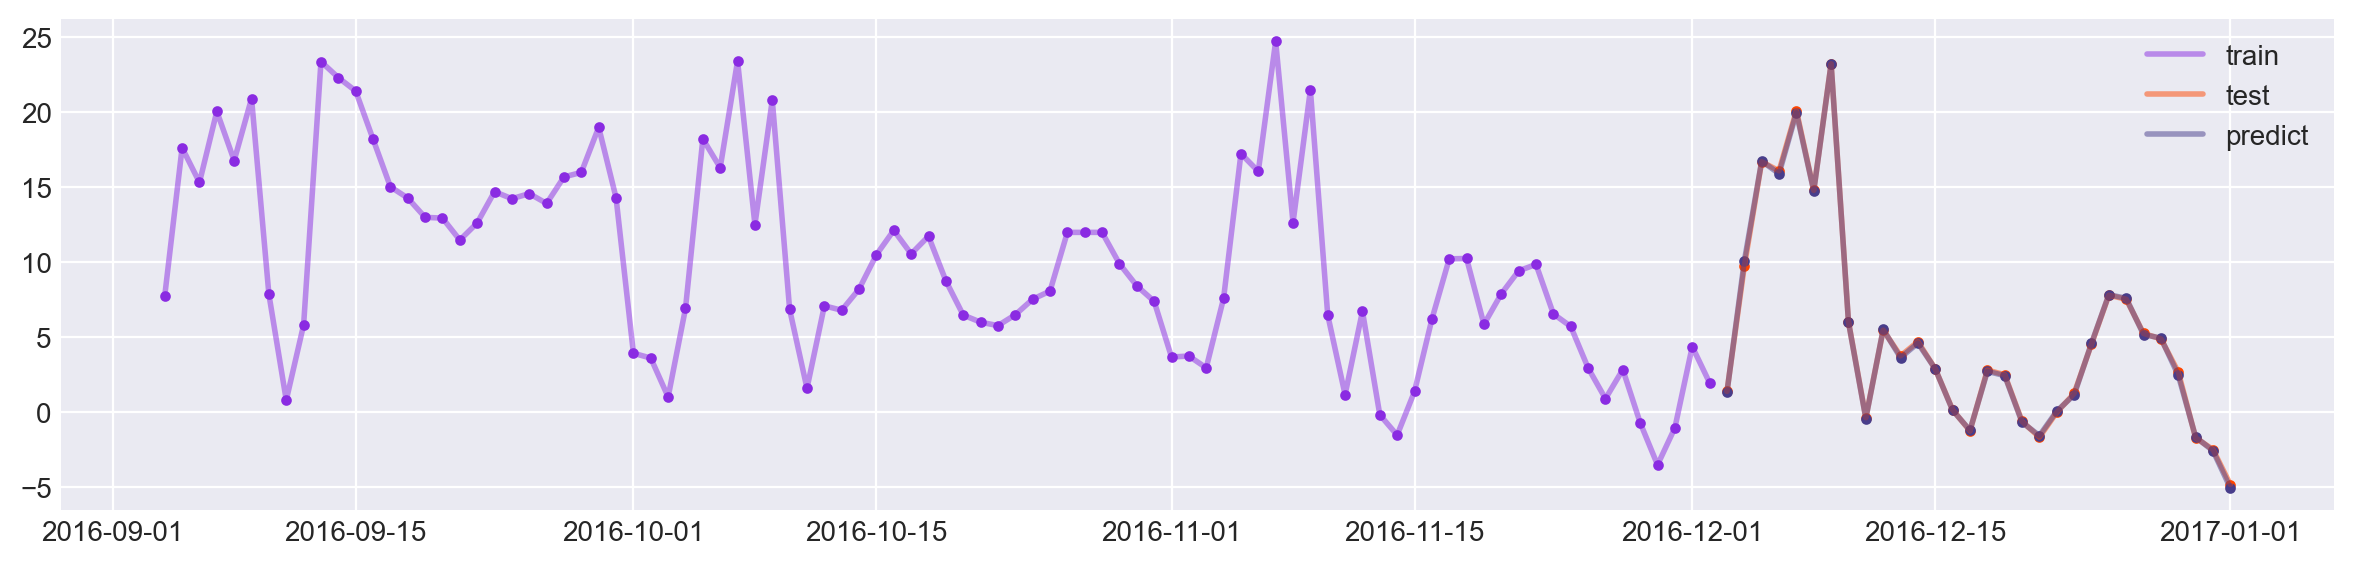

In [20]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [21]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 10.9296087	test: 12.1356013	best: 12.1356013 (0)	total: 168ms	remaining: 2m 48s
1:	learn: 9.9212928	test: 11.0589444	best: 11.0589444 (1)	total: 177ms	remaining: 1m 28s
2:	learn: 9.0057975	test: 10.0475576	best: 10.0475576 (2)	total: 182ms	remaining: 1m
3:	learn: 8.1766972	test: 9.1153752	best: 9.1153752 (3)	total: 187ms	remaining: 46.5s
4:	learn: 7.4324616	test: 8.2840763	best: 8.2840763 (4)	total: 190ms	remaining: 37.7s
5:	learn: 6.7628841	test: 7.5542336	best: 7.5542336 (5)	total: 195ms	remaining: 32.3s
6:	learn: 6.1695219	test: 6.8810538	best: 6.8810538 (6)	total: 199ms	remaining: 28.3s
7:	learn: 5.6265094	test: 6.2996425	best: 6.2996425 (7)	total: 205ms	remaining: 25.4s
8:	learn: 5.1506597	test: 5.7623387	best: 5.7623387 (8)	total: 225ms	remaining: 24.8s
9:	learn: 4.7089423	test: 5.2771349	best: 5.2771349 (9)	total: 241ms	remaining: 23.9s
10:	learn: 4.3120583	test: 4.8429602	best: 4.8429602 (10)	total: 279ms	remaining: 25.1s
11:	learn: 3.9338623	test: 4.4317509	best: 4.4

97:	learn: 0.3681798	test: 0.3752813	best: 0.3752813 (97)	total: 2.19s	remaining: 20.1s
98:	learn: 0.3669562	test: 0.3745981	best: 0.3745981 (98)	total: 2.2s	remaining: 20s
99:	learn: 0.3661795	test: 0.3739404	best: 0.3739404 (99)	total: 2.22s	remaining: 20s
100:	learn: 0.3643210	test: 0.3734030	best: 0.3734030 (100)	total: 2.27s	remaining: 20.2s
101:	learn: 0.3623524	test: 0.3720886	best: 0.3720886 (101)	total: 2.31s	remaining: 20.3s
102:	learn: 0.3613541	test: 0.3717302	best: 0.3717302 (102)	total: 2.33s	remaining: 20.3s
103:	learn: 0.3588829	test: 0.3695647	best: 0.3695647 (103)	total: 2.35s	remaining: 20.3s
104:	learn: 0.3572735	test: 0.3685047	best: 0.3685047 (104)	total: 2.37s	remaining: 20.2s
105:	learn: 0.3562879	test: 0.3683235	best: 0.3683235 (105)	total: 2.39s	remaining: 20.1s
106:	learn: 0.3552550	test: 0.3677916	best: 0.3677916 (106)	total: 2.39s	remaining: 19.9s
107:	learn: 0.3540986	test: 0.3670598	best: 0.3670598 (107)	total: 2.39s	remaining: 19.8s
108:	learn: 0.3534229

196:	learn: 0.2688416	test: 0.3196616	best: 0.3196616 (196)	total: 4.62s	remaining: 18.8s
197:	learn: 0.2682889	test: 0.3196080	best: 0.3196080 (197)	total: 4.62s	remaining: 18.7s
198:	learn: 0.2679177	test: 0.3195740	best: 0.3195740 (198)	total: 4.62s	remaining: 18.6s
199:	learn: 0.2668806	test: 0.3190196	best: 0.3190196 (199)	total: 4.63s	remaining: 18.5s
200:	learn: 0.2661300	test: 0.3181055	best: 0.3181055 (200)	total: 4.63s	remaining: 18.4s
201:	learn: 0.2644463	test: 0.3166891	best: 0.3166891 (201)	total: 4.63s	remaining: 18.3s
202:	learn: 0.2638318	test: 0.3160339	best: 0.3160339 (202)	total: 4.64s	remaining: 18.2s
203:	learn: 0.2629232	test: 0.3153128	best: 0.3153128 (203)	total: 4.65s	remaining: 18.2s
204:	learn: 0.2625835	test: 0.3152112	best: 0.3152112 (204)	total: 4.69s	remaining: 18.2s
205:	learn: 0.2618305	test: 0.3147689	best: 0.3147689 (205)	total: 4.74s	remaining: 18.3s
206:	learn: 0.2614722	test: 0.3145544	best: 0.3145544 (206)	total: 4.76s	remaining: 18.2s
207:	learn

291:	learn: 0.2192943	test: 0.2893802	best: 0.2893802 (291)	total: 6.82s	remaining: 16.5s
292:	learn: 0.2191162	test: 0.2893728	best: 0.2893728 (292)	total: 6.86s	remaining: 16.6s
293:	learn: 0.2188911	test: 0.2893490	best: 0.2893490 (293)	total: 6.88s	remaining: 16.5s
294:	learn: 0.2183660	test: 0.2890629	best: 0.2890629 (294)	total: 6.9s	remaining: 16.5s
295:	learn: 0.2180778	test: 0.2890376	best: 0.2890376 (295)	total: 6.93s	remaining: 16.5s
296:	learn: 0.2177467	test: 0.2886212	best: 0.2886212 (296)	total: 6.98s	remaining: 16.5s
297:	learn: 0.2171438	test: 0.2880657	best: 0.2880657 (297)	total: 7.02s	remaining: 16.5s
298:	learn: 0.2169092	test: 0.2879050	best: 0.2879050 (298)	total: 7.03s	remaining: 16.5s
299:	learn: 0.2165601	test: 0.2878477	best: 0.2878477 (299)	total: 7.04s	remaining: 16.4s
300:	learn: 0.2161370	test: 0.2875482	best: 0.2875482 (300)	total: 7.04s	remaining: 16.3s
301:	learn: 0.2150250	test: 0.2865719	best: 0.2865719 (301)	total: 7.04s	remaining: 16.3s
302:	learn:

388:	learn: 0.1860905	test: 0.2667425	best: 0.2667425 (388)	total: 9.1s	remaining: 14.3s
389:	learn: 0.1857982	test: 0.2664815	best: 0.2664815 (389)	total: 9.1s	remaining: 14.2s
390:	learn: 0.1855907	test: 0.2665101	best: 0.2664815 (389)	total: 9.1s	remaining: 14.2s
391:	learn: 0.1851780	test: 0.2662341	best: 0.2662341 (391)	total: 9.11s	remaining: 14.1s
392:	learn: 0.1848560	test: 0.2658226	best: 0.2658226 (392)	total: 9.11s	remaining: 14.1s
393:	learn: 0.1845621	test: 0.2656777	best: 0.2656777 (393)	total: 9.12s	remaining: 14s
394:	learn: 0.1842588	test: 0.2658682	best: 0.2656777 (393)	total: 9.12s	remaining: 14s
395:	learn: 0.1839675	test: 0.2656878	best: 0.2656777 (393)	total: 9.13s	remaining: 13.9s
396:	learn: 0.1835124	test: 0.2653422	best: 0.2653422 (396)	total: 9.15s	remaining: 13.9s
397:	learn: 0.1826771	test: 0.2645452	best: 0.2645452 (397)	total: 9.19s	remaining: 13.9s
398:	learn: 0.1824028	test: 0.2645442	best: 0.2645442 (398)	total: 9.25s	remaining: 13.9s
399:	learn: 0.182

485:	learn: 0.1613743	test: 0.2516960	best: 0.2516960 (485)	total: 11s	remaining: 11.7s
486:	learn: 0.1612108	test: 0.2516646	best: 0.2516646 (486)	total: 11.1s	remaining: 11.6s
487:	learn: 0.1610442	test: 0.2514421	best: 0.2514421 (487)	total: 11.1s	remaining: 11.6s
488:	learn: 0.1607974	test: 0.2512749	best: 0.2512749 (488)	total: 11.1s	remaining: 11.6s
489:	learn: 0.1606764	test: 0.2512787	best: 0.2512749 (488)	total: 11.1s	remaining: 11.5s
490:	learn: 0.1604671	test: 0.2511367	best: 0.2511367 (490)	total: 11.1s	remaining: 11.5s
491:	learn: 0.1602915	test: 0.2510801	best: 0.2510801 (491)	total: 11.1s	remaining: 11.5s
492:	learn: 0.1600920	test: 0.2510502	best: 0.2510502 (492)	total: 11.2s	remaining: 11.5s
493:	learn: 0.1598025	test: 0.2508277	best: 0.2508277 (493)	total: 11.2s	remaining: 11.5s
494:	learn: 0.1596682	test: 0.2508045	best: 0.2508045 (494)	total: 11.2s	remaining: 11.4s
495:	learn: 0.1594893	test: 0.2508209	best: 0.2508045 (494)	total: 11.2s	remaining: 11.4s
496:	learn: 

577:	learn: 0.1446122	test: 0.2439083	best: 0.2439083 (577)	total: 13.2s	remaining: 9.63s
578:	learn: 0.1442585	test: 0.2437309	best: 0.2437309 (578)	total: 13.2s	remaining: 9.59s
579:	learn: 0.1440543	test: 0.2434763	best: 0.2434763 (579)	total: 13.2s	remaining: 9.56s
580:	learn: 0.1437941	test: 0.2432060	best: 0.2432060 (580)	total: 13.2s	remaining: 9.52s
581:	learn: 0.1435949	test: 0.2431854	best: 0.2431854 (581)	total: 13.2s	remaining: 9.5s
582:	learn: 0.1433792	test: 0.2430772	best: 0.2430772 (582)	total: 13.3s	remaining: 9.49s
583:	learn: 0.1432502	test: 0.2431277	best: 0.2430772 (582)	total: 13.3s	remaining: 9.48s
584:	learn: 0.1431315	test: 0.2431889	best: 0.2430772 (582)	total: 13.3s	remaining: 9.46s
585:	learn: 0.1429350	test: 0.2430682	best: 0.2430682 (585)	total: 13.4s	remaining: 9.44s
586:	learn: 0.1428017	test: 0.2431747	best: 0.2430682 (585)	total: 13.4s	remaining: 9.41s
587:	learn: 0.1427419	test: 0.2431420	best: 0.2430682 (585)	total: 13.4s	remaining: 9.39s
588:	learn:

671:	learn: 0.1300554	test: 0.2365486	best: 0.2364896 (670)	total: 15.4s	remaining: 7.51s
672:	learn: 0.1298980	test: 0.2364367	best: 0.2364367 (672)	total: 15.4s	remaining: 7.51s
673:	learn: 0.1298602	test: 0.2363794	best: 0.2363794 (673)	total: 15.5s	remaining: 7.48s
674:	learn: 0.1295874	test: 0.2361854	best: 0.2361854 (674)	total: 15.5s	remaining: 7.46s
675:	learn: 0.1294605	test: 0.2361049	best: 0.2361049 (675)	total: 15.5s	remaining: 7.43s
676:	learn: 0.1293418	test: 0.2360365	best: 0.2360365 (676)	total: 15.5s	remaining: 7.41s
677:	learn: 0.1292196	test: 0.2360243	best: 0.2360243 (677)	total: 15.6s	remaining: 7.39s
678:	learn: 0.1290305	test: 0.2360169	best: 0.2360169 (678)	total: 15.6s	remaining: 7.38s
679:	learn: 0.1288925	test: 0.2359524	best: 0.2359524 (679)	total: 15.6s	remaining: 7.36s
680:	learn: 0.1288252	test: 0.2359887	best: 0.2359524 (679)	total: 15.7s	remaining: 7.34s
681:	learn: 0.1286816	test: 0.2360065	best: 0.2359524 (679)	total: 15.7s	remaining: 7.31s
682:	learn

768:	learn: 0.1166115	test: 0.2293074	best: 0.2293074 (768)	total: 18.1s	remaining: 5.45s
769:	learn: 0.1165181	test: 0.2292873	best: 0.2292873 (769)	total: 18.1s	remaining: 5.42s
770:	learn: 0.1164139	test: 0.2292189	best: 0.2292189 (770)	total: 18.1s	remaining: 5.39s
771:	learn: 0.1162565	test: 0.2291666	best: 0.2291666 (771)	total: 18.2s	remaining: 5.36s
772:	learn: 0.1161875	test: 0.2292294	best: 0.2291666 (771)	total: 18.2s	remaining: 5.33s
773:	learn: 0.1161158	test: 0.2291741	best: 0.2291666 (771)	total: 18.2s	remaining: 5.3s
774:	learn: 0.1160114	test: 0.2291181	best: 0.2291181 (774)	total: 18.2s	remaining: 5.27s
775:	learn: 0.1158746	test: 0.2289569	best: 0.2289569 (775)	total: 18.2s	remaining: 5.25s
776:	learn: 0.1157134	test: 0.2289868	best: 0.2289569 (775)	total: 18.2s	remaining: 5.23s
777:	learn: 0.1155799	test: 0.2289692	best: 0.2289569 (775)	total: 18.2s	remaining: 5.2s
778:	learn: 0.1153907	test: 0.2289487	best: 0.2289487 (778)	total: 18.3s	remaining: 5.18s
779:	learn: 

862:	learn: 0.1068487	test: 0.2256698	best: 0.2255865 (860)	total: 20.5s	remaining: 3.25s
863:	learn: 0.1067233	test: 0.2256297	best: 0.2255865 (860)	total: 20.5s	remaining: 3.23s
864:	learn: 0.1066607	test: 0.2255608	best: 0.2255608 (864)	total: 20.6s	remaining: 3.21s
865:	learn: 0.1065784	test: 0.2255404	best: 0.2255404 (865)	total: 20.6s	remaining: 3.19s
866:	learn: 0.1064793	test: 0.2255449	best: 0.2255404 (865)	total: 20.6s	remaining: 3.16s
867:	learn: 0.1063840	test: 0.2254862	best: 0.2254862 (867)	total: 20.7s	remaining: 3.14s
868:	learn: 0.1063499	test: 0.2254908	best: 0.2254862 (867)	total: 20.7s	remaining: 3.12s
869:	learn: 0.1062728	test: 0.2255280	best: 0.2254862 (867)	total: 20.7s	remaining: 3.09s
870:	learn: 0.1062096	test: 0.2255604	best: 0.2254862 (867)	total: 20.7s	remaining: 3.07s
871:	learn: 0.1061126	test: 0.2255630	best: 0.2254862 (867)	total: 20.7s	remaining: 3.04s
872:	learn: 0.1059831	test: 0.2255492	best: 0.2254862 (867)	total: 20.8s	remaining: 3.02s
873:	learn

956:	learn: 0.0976774	test: 0.2225036	best: 0.2225036 (956)	total: 22.9s	remaining: 1.03s
957:	learn: 0.0975451	test: 0.2225590	best: 0.2225036 (956)	total: 22.9s	remaining: 1.01s
958:	learn: 0.0974689	test: 0.2225708	best: 0.2225036 (956)	total: 23s	remaining: 983ms
959:	learn: 0.0973831	test: 0.2224676	best: 0.2224676 (959)	total: 23s	remaining: 960ms
960:	learn: 0.0972783	test: 0.2224771	best: 0.2224676 (959)	total: 23.1s	remaining: 936ms
961:	learn: 0.0971375	test: 0.2224343	best: 0.2224343 (961)	total: 23.1s	remaining: 912ms
962:	learn: 0.0970721	test: 0.2224488	best: 0.2224343 (961)	total: 23.1s	remaining: 888ms
963:	learn: 0.0969962	test: 0.2224925	best: 0.2224343 (961)	total: 23.1s	remaining: 863ms
964:	learn: 0.0968944	test: 0.2225316	best: 0.2224343 (961)	total: 23.1s	remaining: 839ms
965:	learn: 0.0967934	test: 0.2224420	best: 0.2224343 (961)	total: 23.2s	remaining: 816ms
966:	learn: 0.0966873	test: 0.2223768	best: 0.2223768 (966)	total: 23.2s	remaining: 793ms
967:	learn: 0.

51:	learn: 0.5312182	test: 0.5089400	best: 0.5089400 (51)	total: 1.14s	remaining: 20.8s
52:	learn: 0.5226700	test: 0.5007964	best: 0.5007964 (52)	total: 1.16s	remaining: 20.8s
53:	learn: 0.5150356	test: 0.4913312	best: 0.4913312 (53)	total: 1.18s	remaining: 20.7s
54:	learn: 0.5079409	test: 0.4848860	best: 0.4848860 (54)	total: 1.2s	remaining: 20.6s
55:	learn: 0.5016903	test: 0.4798352	best: 0.4798352 (55)	total: 1.24s	remaining: 21s
56:	learn: 0.4948561	test: 0.4754076	best: 0.4754076 (56)	total: 1.28s	remaining: 21.3s
57:	learn: 0.4862693	test: 0.4670243	best: 0.4670243 (57)	total: 1.3s	remaining: 21.2s
58:	learn: 0.4786531	test: 0.4580323	best: 0.4580323 (58)	total: 1.34s	remaining: 21.3s
59:	learn: 0.4747989	test: 0.4559195	best: 0.4559195 (59)	total: 1.36s	remaining: 21.3s
60:	learn: 0.4707718	test: 0.4525734	best: 0.4525734 (60)	total: 1.38s	remaining: 21.2s
61:	learn: 0.4660972	test: 0.4476808	best: 0.4476808 (61)	total: 1.4s	remaining: 21.1s
62:	learn: 0.4610533	test: 0.4439854	

149:	learn: 0.3141437	test: 0.3429186	best: 0.3429186 (149)	total: 3.32s	remaining: 18.8s
150:	learn: 0.3131343	test: 0.3427002	best: 0.3427002 (150)	total: 3.34s	remaining: 18.8s
151:	learn: 0.3120633	test: 0.3417871	best: 0.3417871 (151)	total: 3.37s	remaining: 18.8s
152:	learn: 0.3110717	test: 0.3407102	best: 0.3407102 (152)	total: 3.4s	remaining: 18.8s
153:	learn: 0.3092702	test: 0.3390251	best: 0.3390251 (153)	total: 3.42s	remaining: 18.8s
154:	learn: 0.3082098	test: 0.3385601	best: 0.3385601 (154)	total: 3.44s	remaining: 18.8s
155:	learn: 0.3075326	test: 0.3381746	best: 0.3381746 (155)	total: 3.46s	remaining: 18.7s
156:	learn: 0.3071186	test: 0.3381498	best: 0.3381498 (156)	total: 3.54s	remaining: 19s
157:	learn: 0.3059874	test: 0.3370987	best: 0.3370987 (157)	total: 3.57s	remaining: 19s
158:	learn: 0.3049421	test: 0.3367000	best: 0.3367000 (158)	total: 3.59s	remaining: 19s
159:	learn: 0.3039052	test: 0.3356913	best: 0.3356913 (159)	total: 3.62s	remaining: 19s
160:	learn: 0.30349

243:	learn: 0.2493482	test: 0.3013602	best: 0.3012902 (242)	total: 5.46s	remaining: 16.9s
244:	learn: 0.2489163	test: 0.3010754	best: 0.3010754 (244)	total: 5.48s	remaining: 16.9s
245:	learn: 0.2485126	test: 0.3006084	best: 0.3006084 (245)	total: 5.49s	remaining: 16.8s
246:	learn: 0.2482535	test: 0.3005473	best: 0.3005473 (246)	total: 5.51s	remaining: 16.8s
247:	learn: 0.2480340	test: 0.3003123	best: 0.3003123 (247)	total: 5.51s	remaining: 16.7s
248:	learn: 0.2475905	test: 0.3002233	best: 0.3002233 (248)	total: 5.55s	remaining: 16.7s
249:	learn: 0.2471339	test: 0.3000227	best: 0.3000227 (249)	total: 5.58s	remaining: 16.8s
250:	learn: 0.2465576	test: 0.2997812	best: 0.2997812 (250)	total: 5.61s	remaining: 16.7s
251:	learn: 0.2463295	test: 0.2994703	best: 0.2994703 (251)	total: 5.63s	remaining: 16.7s
252:	learn: 0.2461863	test: 0.2993060	best: 0.2993060 (252)	total: 5.65s	remaining: 16.7s
253:	learn: 0.2456012	test: 0.2993386	best: 0.2993060 (252)	total: 5.68s	remaining: 16.7s
254:	learn

335:	learn: 0.2121219	test: 0.2772022	best: 0.2772022 (335)	total: 7.61s	remaining: 15s
336:	learn: 0.2120759	test: 0.2772221	best: 0.2772022 (335)	total: 7.62s	remaining: 15s
337:	learn: 0.2118198	test: 0.2771678	best: 0.2771678 (337)	total: 7.62s	remaining: 14.9s
338:	learn: 0.2115136	test: 0.2770214	best: 0.2770214 (338)	total: 7.63s	remaining: 14.9s
339:	learn: 0.2114153	test: 0.2770350	best: 0.2770214 (338)	total: 7.65s	remaining: 14.9s
340:	learn: 0.2113646	test: 0.2770508	best: 0.2770214 (338)	total: 7.7s	remaining: 14.9s
341:	learn: 0.2113157	test: 0.2770694	best: 0.2770214 (338)	total: 7.73s	remaining: 14.9s
342:	learn: 0.2110159	test: 0.2770010	best: 0.2770010 (342)	total: 7.75s	remaining: 14.8s
343:	learn: 0.2108075	test: 0.2769861	best: 0.2769861 (343)	total: 7.77s	remaining: 14.8s
344:	learn: 0.2105738	test: 0.2769577	best: 0.2769577 (344)	total: 7.78s	remaining: 14.8s
345:	learn: 0.2102807	test: 0.2769720	best: 0.2769577 (344)	total: 7.78s	remaining: 14.7s
346:	learn: 0.2

429:	learn: 0.1856264	test: 0.2620384	best: 0.2620241 (428)	total: 9.63s	remaining: 12.8s
430:	learn: 0.1854646	test: 0.2618775	best: 0.2618775 (430)	total: 9.66s	remaining: 12.8s
431:	learn: 0.1850905	test: 0.2616155	best: 0.2616155 (431)	total: 9.69s	remaining: 12.7s
432:	learn: 0.1850280	test: 0.2616109	best: 0.2616109 (432)	total: 9.71s	remaining: 12.7s
433:	learn: 0.1849308	test: 0.2616699	best: 0.2616109 (432)	total: 9.73s	remaining: 12.7s
434:	learn: 0.1847383	test: 0.2615680	best: 0.2615680 (434)	total: 9.74s	remaining: 12.7s
435:	learn: 0.1843652	test: 0.2614549	best: 0.2614549 (435)	total: 9.86s	remaining: 12.8s
436:	learn: 0.1839747	test: 0.2610964	best: 0.2610964 (436)	total: 9.87s	remaining: 12.7s
437:	learn: 0.1836325	test: 0.2609701	best: 0.2609701 (437)	total: 9.87s	remaining: 12.7s
438:	learn: 0.1834998	test: 0.2608846	best: 0.2608846 (438)	total: 9.88s	remaining: 12.6s
439:	learn: 0.1831607	test: 0.2607867	best: 0.2607867 (439)	total: 9.9s	remaining: 12.6s
440:	learn:

523:	learn: 0.1639243	test: 0.2504508	best: 0.2504432 (522)	total: 11.6s	remaining: 10.5s
524:	learn: 0.1636504	test: 0.2502938	best: 0.2502938 (524)	total: 11.6s	remaining: 10.5s
525:	learn: 0.1635086	test: 0.2501324	best: 0.2501324 (525)	total: 11.6s	remaining: 10.5s
526:	learn: 0.1633312	test: 0.2498756	best: 0.2498756 (526)	total: 11.6s	remaining: 10.4s
527:	learn: 0.1631600	test: 0.2499758	best: 0.2498756 (526)	total: 11.6s	remaining: 10.4s
528:	learn: 0.1630739	test: 0.2498887	best: 0.2498756 (526)	total: 11.6s	remaining: 10.3s
529:	learn: 0.1629510	test: 0.2497840	best: 0.2497840 (529)	total: 11.6s	remaining: 10.3s
530:	learn: 0.1628310	test: 0.2497680	best: 0.2497680 (530)	total: 11.6s	remaining: 10.3s
531:	learn: 0.1626830	test: 0.2496893	best: 0.2496893 (531)	total: 11.6s	remaining: 10.2s
532:	learn: 0.1624367	test: 0.2496137	best: 0.2496137 (532)	total: 11.6s	remaining: 10.2s
533:	learn: 0.1623113	test: 0.2495113	best: 0.2495113 (533)	total: 11.7s	remaining: 10.2s
534:	learn

626:	learn: 0.1458359	test: 0.2407317	best: 0.2406367 (625)	total: 14s	remaining: 8.34s
627:	learn: 0.1457144	test: 0.2405878	best: 0.2405878 (627)	total: 14s	remaining: 8.32s
628:	learn: 0.1455242	test: 0.2404422	best: 0.2404422 (628)	total: 14.1s	remaining: 8.3s
629:	learn: 0.1452512	test: 0.2401838	best: 0.2401838 (629)	total: 14.1s	remaining: 8.27s
630:	learn: 0.1452054	test: 0.2401590	best: 0.2401590 (630)	total: 14.1s	remaining: 8.27s
631:	learn: 0.1450616	test: 0.2401840	best: 0.2401590 (630)	total: 14.2s	remaining: 8.26s
632:	learn: 0.1449396	test: 0.2401082	best: 0.2401082 (632)	total: 14.2s	remaining: 8.23s
633:	learn: 0.1447813	test: 0.2400246	best: 0.2400246 (633)	total: 14.2s	remaining: 8.21s
634:	learn: 0.1445908	test: 0.2399592	best: 0.2399592 (634)	total: 14.2s	remaining: 8.18s
635:	learn: 0.1443201	test: 0.2398533	best: 0.2398533 (635)	total: 14.2s	remaining: 8.14s
636:	learn: 0.1441741	test: 0.2398465	best: 0.2398465 (636)	total: 14.2s	remaining: 8.11s
637:	learn: 0.1

723:	learn: 0.1308681	test: 0.2326944	best: 0.2326944 (723)	total: 16.2s	remaining: 6.18s
724:	learn: 0.1307330	test: 0.2326635	best: 0.2326635 (724)	total: 16.2s	remaining: 6.15s
725:	learn: 0.1306317	test: 0.2326415	best: 0.2326415 (725)	total: 16.2s	remaining: 6.13s
726:	learn: 0.1305337	test: 0.2325860	best: 0.2325860 (726)	total: 16.3s	remaining: 6.12s
727:	learn: 0.1304374	test: 0.2324332	best: 0.2324332 (727)	total: 16.3s	remaining: 6.1s
728:	learn: 0.1302914	test: 0.2324000	best: 0.2324000 (728)	total: 16.4s	remaining: 6.08s
729:	learn: 0.1301155	test: 0.2321327	best: 0.2321327 (729)	total: 16.4s	remaining: 6.07s
730:	learn: 0.1300032	test: 0.2320466	best: 0.2320466 (730)	total: 16.4s	remaining: 6.05s
731:	learn: 0.1299230	test: 0.2320399	best: 0.2320399 (731)	total: 16.5s	remaining: 6.02s
732:	learn: 0.1298525	test: 0.2320404	best: 0.2320399 (731)	total: 16.5s	remaining: 6s
733:	learn: 0.1296801	test: 0.2319488	best: 0.2319488 (733)	total: 16.5s	remaining: 5.98s
734:	learn: 0.

817:	learn: 0.1194472	test: 0.2273836	best: 0.2273671 (816)	total: 18.7s	remaining: 4.16s
818:	learn: 0.1193310	test: 0.2272848	best: 0.2272848 (818)	total: 18.7s	remaining: 4.13s
819:	learn: 0.1192168	test: 0.2273151	best: 0.2272848 (818)	total: 18.7s	remaining: 4.11s
820:	learn: 0.1190990	test: 0.2272537	best: 0.2272537 (820)	total: 18.8s	remaining: 4.09s
821:	learn: 0.1190839	test: 0.2272504	best: 0.2272504 (821)	total: 18.8s	remaining: 4.07s
822:	learn: 0.1189150	test: 0.2271117	best: 0.2271117 (822)	total: 18.8s	remaining: 4.04s
823:	learn: 0.1187464	test: 0.2270019	best: 0.2270019 (823)	total: 18.8s	remaining: 4.02s
824:	learn: 0.1185704	test: 0.2268817	best: 0.2268817 (824)	total: 18.9s	remaining: 4s
825:	learn: 0.1184237	test: 0.2267366	best: 0.2267366 (825)	total: 18.9s	remaining: 3.98s
826:	learn: 0.1183059	test: 0.2266992	best: 0.2266992 (826)	total: 18.9s	remaining: 3.96s
827:	learn: 0.1182251	test: 0.2267284	best: 0.2266992 (826)	total: 19s	remaining: 3.94s
828:	learn: 0.1

916:	learn: 0.1087182	test: 0.2230567	best: 0.2229904 (913)	total: 21.1s	remaining: 1.91s
917:	learn: 0.1086544	test: 0.2230329	best: 0.2229904 (913)	total: 21.2s	remaining: 1.89s
918:	learn: 0.1085581	test: 0.2229727	best: 0.2229727 (918)	total: 21.2s	remaining: 1.87s
919:	learn: 0.1084224	test: 0.2229135	best: 0.2229135 (919)	total: 21.2s	remaining: 1.84s
920:	learn: 0.1082887	test: 0.2227644	best: 0.2227644 (920)	total: 21.2s	remaining: 1.82s
921:	learn: 0.1082045	test: 0.2227573	best: 0.2227573 (921)	total: 21.2s	remaining: 1.8s
922:	learn: 0.1080735	test: 0.2226124	best: 0.2226124 (922)	total: 21.3s	remaining: 1.77s
923:	learn: 0.1079852	test: 0.2226461	best: 0.2226124 (922)	total: 21.4s	remaining: 1.76s
924:	learn: 0.1078927	test: 0.2226359	best: 0.2226124 (922)	total: 21.4s	remaining: 1.73s
925:	learn: 0.1078244	test: 0.2225750	best: 0.2225750 (925)	total: 21.4s	remaining: 1.71s
926:	learn: 0.1077268	test: 0.2224370	best: 0.2224370 (926)	total: 21.4s	remaining: 1.68s
927:	learn:

6:	learn: 6.4068604	test: 6.3848577	best: 6.3848577 (6)	total: 128ms	remaining: 18.1s
7:	learn: 5.8289243	test: 5.8480468	best: 5.8480468 (7)	total: 146ms	remaining: 18.1s
8:	learn: 5.3296490	test: 5.3872949	best: 5.3872949 (8)	total: 157ms	remaining: 17.3s
9:	learn: 4.8771489	test: 4.9844770	best: 4.9844770 (9)	total: 179ms	remaining: 17.8s
10:	learn: 4.4640511	test: 4.5902292	best: 4.5902292 (10)	total: 196ms	remaining: 17.6s
11:	learn: 4.0868682	test: 4.2473248	best: 4.2473248 (11)	total: 210ms	remaining: 17.3s
12:	learn: 3.7443702	test: 3.9295177	best: 3.9295177 (12)	total: 224ms	remaining: 17s
13:	learn: 3.4461555	test: 3.6735739	best: 3.6735739 (13)	total: 236ms	remaining: 16.6s
14:	learn: 3.1675474	test: 3.4082850	best: 3.4082850 (14)	total: 247ms	remaining: 16.2s
15:	learn: 2.9125208	test: 3.1380548	best: 3.1380548 (15)	total: 277ms	remaining: 17s
16:	learn: 2.6860432	test: 2.9203888	best: 2.9203888 (16)	total: 310ms	remaining: 17.9s
17:	learn: 2.4778685	test: 2.7144356	best: 2

106:	learn: 0.3778384	test: 0.5666311	best: 0.5666311 (106)	total: 1.81s	remaining: 15.2s
107:	learn: 0.3771506	test: 0.5660833	best: 0.5660833 (107)	total: 1.82s	remaining: 15s
108:	learn: 0.3762694	test: 0.5646907	best: 0.5646907 (108)	total: 1.82s	remaining: 14.9s
109:	learn: 0.3753626	test: 0.5638985	best: 0.5638985 (109)	total: 1.83s	remaining: 14.8s
110:	learn: 0.3737806	test: 0.5630620	best: 0.5630620 (110)	total: 1.83s	remaining: 14.7s
111:	learn: 0.3714412	test: 0.5614360	best: 0.5614360 (111)	total: 1.84s	remaining: 14.6s
112:	learn: 0.3706379	test: 0.5613314	best: 0.5613314 (112)	total: 1.88s	remaining: 14.7s
113:	learn: 0.3682561	test: 0.5594126	best: 0.5594126 (113)	total: 1.91s	remaining: 14.8s
114:	learn: 0.3674017	test: 0.5594955	best: 0.5594126 (113)	total: 1.93s	remaining: 14.9s
115:	learn: 0.3653690	test: 0.5580195	best: 0.5580195 (115)	total: 1.95s	remaining: 14.8s
116:	learn: 0.3640889	test: 0.5572990	best: 0.5572990 (116)	total: 1.96s	remaining: 14.8s
117:	learn: 

210:	learn: 0.2777308	test: 0.5126222	best: 0.5126222 (210)	total: 3.56s	remaining: 13.3s
211:	learn: 0.2769247	test: 0.5124412	best: 0.5124412 (211)	total: 3.57s	remaining: 13.3s
212:	learn: 0.2761400	test: 0.5117656	best: 0.5117656 (212)	total: 3.6s	remaining: 13.3s
213:	learn: 0.2753577	test: 0.5115712	best: 0.5115712 (213)	total: 3.63s	remaining: 13.3s
214:	learn: 0.2745183	test: 0.5106402	best: 0.5106402 (214)	total: 3.66s	remaining: 13.4s
215:	learn: 0.2738788	test: 0.5105652	best: 0.5105652 (215)	total: 3.68s	remaining: 13.3s
216:	learn: 0.2731398	test: 0.5101289	best: 0.5101289 (216)	total: 3.69s	remaining: 13.3s
217:	learn: 0.2727431	test: 0.5101172	best: 0.5101172 (217)	total: 3.71s	remaining: 13.3s
218:	learn: 0.2718461	test: 0.5100201	best: 0.5100201 (218)	total: 3.72s	remaining: 13.3s
219:	learn: 0.2714918	test: 0.5095690	best: 0.5095690 (219)	total: 3.73s	remaining: 13.2s
220:	learn: 0.2707121	test: 0.5093091	best: 0.5093091 (220)	total: 3.74s	remaining: 13.2s
221:	learn:

307:	learn: 0.2223169	test: 0.4868729	best: 0.4868729 (307)	total: 5.27s	remaining: 11.8s
308:	learn: 0.2218853	test: 0.4869861	best: 0.4868729 (307)	total: 5.28s	remaining: 11.8s
309:	learn: 0.2214321	test: 0.4868417	best: 0.4868417 (309)	total: 5.28s	remaining: 11.7s
310:	learn: 0.2207477	test: 0.4867119	best: 0.4867119 (310)	total: 5.28s	remaining: 11.7s
311:	learn: 0.2206367	test: 0.4867686	best: 0.4867119 (310)	total: 5.28s	remaining: 11.7s
312:	learn: 0.2197101	test: 0.4863455	best: 0.4863455 (312)	total: 5.29s	remaining: 11.6s
313:	learn: 0.2188172	test: 0.4859639	best: 0.4859639 (313)	total: 5.29s	remaining: 11.6s
314:	learn: 0.2185820	test: 0.4858209	best: 0.4858209 (314)	total: 5.3s	remaining: 11.5s
315:	learn: 0.2183885	test: 0.4854674	best: 0.4854674 (315)	total: 5.3s	remaining: 11.5s
316:	learn: 0.2179736	test: 0.4852580	best: 0.4852580 (316)	total: 5.32s	remaining: 11.5s
317:	learn: 0.2177610	test: 0.4858170	best: 0.4852580 (316)	total: 5.33s	remaining: 11.4s
318:	learn: 

412:	learn: 0.1845577	test: 0.4737721	best: 0.4737721 (412)	total: 7s	remaining: 9.94s
413:	learn: 0.1838940	test: 0.4734156	best: 0.4734156 (413)	total: 7s	remaining: 9.91s
414:	learn: 0.1835409	test: 0.4733265	best: 0.4733265 (414)	total: 7s	remaining: 9.88s
415:	learn: 0.1831212	test: 0.4735447	best: 0.4733265 (414)	total: 7.01s	remaining: 9.85s
416:	learn: 0.1826691	test: 0.4735123	best: 0.4733265 (414)	total: 7.04s	remaining: 9.84s
417:	learn: 0.1823941	test: 0.4733663	best: 0.4733265 (414)	total: 7.07s	remaining: 9.84s
418:	learn: 0.1819672	test: 0.4732010	best: 0.4732010 (418)	total: 7.09s	remaining: 9.84s
419:	learn: 0.1817123	test: 0.4733200	best: 0.4732010 (418)	total: 7.11s	remaining: 9.82s
420:	learn: 0.1811193	test: 0.4731467	best: 0.4731467 (420)	total: 7.13s	remaining: 9.8s
421:	learn: 0.1810001	test: 0.4732448	best: 0.4731467 (420)	total: 7.14s	remaining: 9.78s
422:	learn: 0.1808122	test: 0.4733189	best: 0.4731467 (420)	total: 7.18s	remaining: 9.8s
423:	learn: 0.1800717

513:	learn: 0.1575815	test: 0.4676201	best: 0.4676201 (513)	total: 8.96s	remaining: 8.47s
514:	learn: 0.1574892	test: 0.4677232	best: 0.4676201 (513)	total: 8.97s	remaining: 8.45s
515:	learn: 0.1570174	test: 0.4674726	best: 0.4674726 (515)	total: 8.99s	remaining: 8.43s
516:	learn: 0.1567483	test: 0.4673296	best: 0.4673296 (516)	total: 9.01s	remaining: 8.42s
517:	learn: 0.1564670	test: 0.4671305	best: 0.4671305 (517)	total: 9.03s	remaining: 8.4s
518:	learn: 0.1564020	test: 0.4670587	best: 0.4670587 (518)	total: 9.04s	remaining: 8.38s
519:	learn: 0.1560009	test: 0.4668761	best: 0.4668761 (519)	total: 9.05s	remaining: 8.36s
520:	learn: 0.1557205	test: 0.4668635	best: 0.4668635 (520)	total: 9.08s	remaining: 8.35s
521:	learn: 0.1554786	test: 0.4666936	best: 0.4666936 (521)	total: 9.12s	remaining: 8.35s
522:	learn: 0.1553238	test: 0.4665099	best: 0.4665099 (522)	total: 9.15s	remaining: 8.34s
523:	learn: 0.1551251	test: 0.4663355	best: 0.4663355 (523)	total: 9.18s	remaining: 8.34s
524:	learn:

606:	learn: 0.1389576	test: 0.4606776	best: 0.4606776 (606)	total: 10.7s	remaining: 6.94s
607:	learn: 0.1387601	test: 0.4607207	best: 0.4606776 (606)	total: 10.7s	remaining: 6.92s
608:	learn: 0.1386154	test: 0.4607541	best: 0.4606776 (606)	total: 10.7s	remaining: 6.9s
609:	learn: 0.1384772	test: 0.4603489	best: 0.4603489 (609)	total: 10.8s	remaining: 6.88s
610:	learn: 0.1383756	test: 0.4603459	best: 0.4603459 (610)	total: 10.8s	remaining: 6.86s
611:	learn: 0.1380614	test: 0.4601919	best: 0.4601919 (611)	total: 10.8s	remaining: 6.85s
612:	learn: 0.1379207	test: 0.4600486	best: 0.4600486 (612)	total: 10.8s	remaining: 6.84s
613:	learn: 0.1377073	test: 0.4600072	best: 0.4600072 (613)	total: 10.9s	remaining: 6.83s
614:	learn: 0.1375565	test: 0.4599793	best: 0.4599793 (614)	total: 10.9s	remaining: 6.81s
615:	learn: 0.1374481	test: 0.4599437	best: 0.4599437 (615)	total: 10.9s	remaining: 6.79s
616:	learn: 0.1372584	test: 0.4597463	best: 0.4597463 (616)	total: 10.9s	remaining: 6.76s
617:	learn:

705:	learn: 0.1242193	test: 0.4570232	best: 0.4570232 (705)	total: 12.6s	remaining: 5.25s
706:	learn: 0.1240855	test: 0.4571405	best: 0.4570232 (705)	total: 12.6s	remaining: 5.24s
707:	learn: 0.1240053	test: 0.4571779	best: 0.4570232 (705)	total: 12.7s	remaining: 5.22s
708:	learn: 0.1238095	test: 0.4571408	best: 0.4570232 (705)	total: 12.7s	remaining: 5.2s
709:	learn: 0.1236700	test: 0.4569981	best: 0.4569981 (709)	total: 12.7s	remaining: 5.18s
710:	learn: 0.1235241	test: 0.4570186	best: 0.4569981 (709)	total: 12.7s	remaining: 5.16s
711:	learn: 0.1233443	test: 0.4569361	best: 0.4569361 (711)	total: 12.7s	remaining: 5.14s
712:	learn: 0.1231247	test: 0.4568809	best: 0.4568809 (712)	total: 12.7s	remaining: 5.12s
713:	learn: 0.1229593	test: 0.4567778	best: 0.4567778 (713)	total: 12.7s	remaining: 5.1s
714:	learn: 0.1228674	test: 0.4567579	best: 0.4567579 (714)	total: 12.7s	remaining: 5.08s
715:	learn: 0.1227210	test: 0.4567137	best: 0.4567137 (715)	total: 12.7s	remaining: 5.06s
716:	learn: 

840:	learn: 0.1069755	test: 0.4538472	best: 0.4536984 (834)	total: 13.2s	remaining: 2.5s
841:	learn: 0.1068476	test: 0.4538490	best: 0.4536984 (834)	total: 13.2s	remaining: 2.48s
842:	learn: 0.1067712	test: 0.4538045	best: 0.4536984 (834)	total: 13.2s	remaining: 2.46s
843:	learn: 0.1066981	test: 0.4538007	best: 0.4536984 (834)	total: 13.2s	remaining: 2.45s
844:	learn: 0.1066381	test: 0.4537725	best: 0.4536984 (834)	total: 13.2s	remaining: 2.43s
845:	learn: 0.1065325	test: 0.4539440	best: 0.4536984 (834)	total: 13.3s	remaining: 2.41s
846:	learn: 0.1064537	test: 0.4539211	best: 0.4536984 (834)	total: 13.3s	remaining: 2.4s
847:	learn: 0.1063183	test: 0.4538678	best: 0.4536984 (834)	total: 13.3s	remaining: 2.38s
848:	learn: 0.1062340	test: 0.4538526	best: 0.4536984 (834)	total: 13.3s	remaining: 2.37s
849:	learn: 0.1060935	test: 0.4538785	best: 0.4536984 (834)	total: 13.3s	remaining: 2.35s
850:	learn: 0.1059980	test: 0.4538663	best: 0.4536984 (834)	total: 13.3s	remaining: 2.33s
851:	learn: 

938:	learn: 0.0963893	test: 0.4517115	best: 0.4516810 (935)	total: 15.4s	remaining: 1s
939:	learn: 0.0961269	test: 0.4516444	best: 0.4516444 (939)	total: 15.4s	remaining: 985ms
940:	learn: 0.0960686	test: 0.4516516	best: 0.4516444 (939)	total: 15.4s	remaining: 969ms
941:	learn: 0.0959611	test: 0.4517686	best: 0.4516444 (939)	total: 15.5s	remaining: 952ms
942:	learn: 0.0957589	test: 0.4517055	best: 0.4516444 (939)	total: 15.5s	remaining: 936ms
943:	learn: 0.0957274	test: 0.4516634	best: 0.4516444 (939)	total: 15.5s	remaining: 921ms
944:	learn: 0.0956209	test: 0.4516703	best: 0.4516444 (939)	total: 15.6s	remaining: 905ms
945:	learn: 0.0954866	test: 0.4516738	best: 0.4516444 (939)	total: 15.6s	remaining: 889ms
946:	learn: 0.0954287	test: 0.4516575	best: 0.4516444 (939)	total: 15.6s	remaining: 872ms
947:	learn: 0.0953496	test: 0.4517107	best: 0.4516444 (939)	total: 15.6s	remaining: 855ms
948:	learn: 0.0952293	test: 0.4516862	best: 0.4516444 (939)	total: 15.6s	remaining: 840ms
949:	learn: 0

30:	learn: 1.0290345	test: 1.1084614	best: 1.1084614 (30)	total: 514ms	remaining: 16.1s
31:	learn: 0.9821799	test: 1.0724834	best: 1.0724834 (31)	total: 517ms	remaining: 15.6s
32:	learn: 0.9318531	test: 1.0228559	best: 1.0228559 (32)	total: 520ms	remaining: 15.2s
33:	learn: 0.8917360	test: 0.9807712	best: 0.9807712 (33)	total: 526ms	remaining: 14.9s
34:	learn: 0.8535900	test: 0.9466433	best: 0.9466433 (34)	total: 531ms	remaining: 14.6s
35:	learn: 0.8219775	test: 0.9167370	best: 0.9167370 (35)	total: 536ms	remaining: 14.3s
36:	learn: 0.7863110	test: 0.8813595	best: 0.8813595 (36)	total: 549ms	remaining: 14.3s
37:	learn: 0.7555152	test: 0.8492859	best: 0.8492859 (37)	total: 581ms	remaining: 14.7s
38:	learn: 0.7279151	test: 0.8196649	best: 0.8196649 (38)	total: 611ms	remaining: 15.1s
39:	learn: 0.7074391	test: 0.7969995	best: 0.7969995 (39)	total: 631ms	remaining: 15.1s
40:	learn: 0.6852386	test: 0.7753166	best: 0.7753166 (40)	total: 653ms	remaining: 15.3s
41:	learn: 0.6651469	test: 0.757

127:	learn: 0.3340147	test: 0.4180692	best: 0.4180692 (127)	total: 2.5s	remaining: 17.1s
128:	learn: 0.3322526	test: 0.4166275	best: 0.4166275 (128)	total: 2.51s	remaining: 16.9s
129:	learn: 0.3309353	test: 0.4154117	best: 0.4154117 (129)	total: 2.51s	remaining: 16.8s
130:	learn: 0.3299669	test: 0.4152367	best: 0.4152367 (130)	total: 2.52s	remaining: 16.7s
131:	learn: 0.3285844	test: 0.4146315	best: 0.4146315 (131)	total: 2.54s	remaining: 16.7s
132:	learn: 0.3276447	test: 0.4136212	best: 0.4136212 (132)	total: 2.56s	remaining: 16.7s
133:	learn: 0.3272070	test: 0.4137184	best: 0.4136212 (132)	total: 2.58s	remaining: 16.7s
134:	learn: 0.3266014	test: 0.4136424	best: 0.4136212 (132)	total: 2.6s	remaining: 16.7s
135:	learn: 0.3260155	test: 0.4130476	best: 0.4130476 (135)	total: 2.62s	remaining: 16.7s
136:	learn: 0.3251179	test: 0.4127280	best: 0.4127280 (136)	total: 2.64s	remaining: 16.6s
137:	learn: 0.3242410	test: 0.4124154	best: 0.4124154 (137)	total: 2.67s	remaining: 16.7s
138:	learn: 

230:	learn: 0.2568916	test: 0.3732880	best: 0.3732880 (230)	total: 4.29s	remaining: 14.3s
231:	learn: 0.2564491	test: 0.3732886	best: 0.3732880 (230)	total: 4.31s	remaining: 14.3s
232:	learn: 0.2562189	test: 0.3731840	best: 0.3731840 (232)	total: 4.33s	remaining: 14.3s
233:	learn: 0.2553516	test: 0.3725197	best: 0.3725197 (233)	total: 4.37s	remaining: 14.3s
234:	learn: 0.2548566	test: 0.3725962	best: 0.3725197 (233)	total: 4.4s	remaining: 14.3s
235:	learn: 0.2544893	test: 0.3724263	best: 0.3724263 (235)	total: 4.42s	remaining: 14.3s
236:	learn: 0.2538628	test: 0.3720602	best: 0.3720602 (236)	total: 4.44s	remaining: 14.3s
237:	learn: 0.2532882	test: 0.3715046	best: 0.3715046 (237)	total: 4.45s	remaining: 14.3s
238:	learn: 0.2525590	test: 0.3711341	best: 0.3711341 (238)	total: 4.46s	remaining: 14.2s
239:	learn: 0.2521025	test: 0.3712630	best: 0.3711341 (238)	total: 4.51s	remaining: 14.3s
240:	learn: 0.2516883	test: 0.3711309	best: 0.3711309 (240)	total: 4.54s	remaining: 14.3s
241:	learn:

327:	learn: 0.2110346	test: 0.3533802	best: 0.3532839 (326)	total: 6.26s	remaining: 12.8s
328:	learn: 0.2106072	test: 0.3533828	best: 0.3532839 (326)	total: 6.29s	remaining: 12.8s
329:	learn: 0.2103793	test: 0.3534136	best: 0.3532839 (326)	total: 6.32s	remaining: 12.8s
330:	learn: 0.2097667	test: 0.3530064	best: 0.3530064 (330)	total: 6.34s	remaining: 12.8s
331:	learn: 0.2093520	test: 0.3528537	best: 0.3528537 (331)	total: 6.36s	remaining: 12.8s
332:	learn: 0.2080650	test: 0.3517397	best: 0.3517397 (332)	total: 6.37s	remaining: 12.8s
333:	learn: 0.2075949	test: 0.3514585	best: 0.3514585 (333)	total: 6.38s	remaining: 12.7s
334:	learn: 0.2072582	test: 0.3512464	best: 0.3512464 (334)	total: 6.39s	remaining: 12.7s
335:	learn: 0.2069566	test: 0.3512834	best: 0.3512464 (334)	total: 6.43s	remaining: 12.7s
336:	learn: 0.2066594	test: 0.3511436	best: 0.3511436 (336)	total: 6.46s	remaining: 12.7s
337:	learn: 0.2063651	test: 0.3510498	best: 0.3510498 (337)	total: 6.51s	remaining: 12.8s
338:	learn

422:	learn: 0.1798509	test: 0.3415128	best: 0.3415128 (422)	total: 8.15s	remaining: 11.1s
423:	learn: 0.1794932	test: 0.3413152	best: 0.3413152 (423)	total: 8.18s	remaining: 11.1s
424:	learn: 0.1791606	test: 0.3409582	best: 0.3409582 (424)	total: 8.2s	remaining: 11.1s
425:	learn: 0.1788587	test: 0.3410787	best: 0.3409582 (424)	total: 8.21s	remaining: 11.1s
426:	learn: 0.1786906	test: 0.3411717	best: 0.3409582 (424)	total: 8.25s	remaining: 11.1s
427:	learn: 0.1784569	test: 0.3411102	best: 0.3409582 (424)	total: 8.28s	remaining: 11.1s
428:	learn: 0.1782024	test: 0.3410882	best: 0.3409582 (424)	total: 8.32s	remaining: 11.1s
429:	learn: 0.1780060	test: 0.3408620	best: 0.3408620 (429)	total: 8.33s	remaining: 11s
430:	learn: 0.1778331	test: 0.3408762	best: 0.3408620 (429)	total: 8.35s	remaining: 11s
431:	learn: 0.1773688	test: 0.3404934	best: 0.3404934 (431)	total: 8.36s	remaining: 11s
432:	learn: 0.1771141	test: 0.3405546	best: 0.3404934 (431)	total: 8.36s	remaining: 11s
433:	learn: 0.17698

522:	learn: 0.1576600	test: 0.3356446	best: 0.3354470 (515)	total: 9.93s	remaining: 9.06s
523:	learn: 0.1574086	test: 0.3357236	best: 0.3354470 (515)	total: 9.96s	remaining: 9.05s
524:	learn: 0.1571334	test: 0.3357366	best: 0.3354470 (515)	total: 9.99s	remaining: 9.04s
525:	learn: 0.1569215	test: 0.3357209	best: 0.3354470 (515)	total: 10s	remaining: 9.01s
526:	learn: 0.1567397	test: 0.3356289	best: 0.3354470 (515)	total: 10s	remaining: 8.99s
527:	learn: 0.1565738	test: 0.3356617	best: 0.3354470 (515)	total: 10s	remaining: 8.97s
528:	learn: 0.1563962	test: 0.3355225	best: 0.3354470 (515)	total: 10.1s	remaining: 8.95s
529:	learn: 0.1561661	test: 0.3354151	best: 0.3354151 (529)	total: 10.1s	remaining: 8.93s
530:	learn: 0.1558704	test: 0.3353114	best: 0.3353114 (530)	total: 10.1s	remaining: 8.91s
531:	learn: 0.1557338	test: 0.3353470	best: 0.3353114 (530)	total: 10.1s	remaining: 8.9s
532:	learn: 0.1555238	test: 0.3352967	best: 0.3352967 (532)	total: 10.2s	remaining: 8.9s
533:	learn: 0.1553

621:	learn: 0.1398303	test: 0.3315617	best: 0.3313304 (619)	total: 11.6s	remaining: 7.07s
622:	learn: 0.1397228	test: 0.3315855	best: 0.3313304 (619)	total: 11.6s	remaining: 7.04s
623:	learn: 0.1396091	test: 0.3316868	best: 0.3313304 (619)	total: 11.6s	remaining: 7.02s
624:	learn: 0.1394561	test: 0.3316763	best: 0.3313304 (619)	total: 11.7s	remaining: 6.99s
625:	learn: 0.1393536	test: 0.3317263	best: 0.3313304 (619)	total: 11.7s	remaining: 6.96s
626:	learn: 0.1391093	test: 0.3315282	best: 0.3313304 (619)	total: 11.7s	remaining: 6.93s
627:	learn: 0.1390053	test: 0.3315821	best: 0.3313304 (619)	total: 11.7s	remaining: 6.91s
628:	learn: 0.1389583	test: 0.3315471	best: 0.3313304 (619)	total: 11.7s	remaining: 6.88s
629:	learn: 0.1388946	test: 0.3315941	best: 0.3313304 (619)	total: 11.7s	remaining: 6.85s
630:	learn: 0.1388102	test: 0.3314984	best: 0.3313304 (619)	total: 11.7s	remaining: 6.82s
631:	learn: 0.1386140	test: 0.3313318	best: 0.3313304 (619)	total: 11.7s	remaining: 6.8s
632:	learn:

715:	learn: 0.1251666	test: 0.3276850	best: 0.3276483 (709)	total: 13.2s	remaining: 5.22s
716:	learn: 0.1249792	test: 0.3275808	best: 0.3275808 (716)	total: 13.2s	remaining: 5.19s
717:	learn: 0.1247790	test: 0.3275288	best: 0.3275288 (717)	total: 13.2s	remaining: 5.17s
718:	learn: 0.1247169	test: 0.3274965	best: 0.3274965 (718)	total: 13.2s	remaining: 5.14s
719:	learn: 0.1245642	test: 0.3273891	best: 0.3273891 (719)	total: 13.2s	remaining: 5.12s
720:	learn: 0.1244724	test: 0.3274131	best: 0.3273891 (719)	total: 13.2s	remaining: 5.1s
721:	learn: 0.1244114	test: 0.3274768	best: 0.3273891 (719)	total: 13.2s	remaining: 5.08s
722:	learn: 0.1242928	test: 0.3274610	best: 0.3273891 (719)	total: 13.2s	remaining: 5.07s
723:	learn: 0.1241890	test: 0.3275150	best: 0.3273891 (719)	total: 13.3s	remaining: 5.06s
724:	learn: 0.1240148	test: 0.3274953	best: 0.3273891 (719)	total: 13.3s	remaining: 5.04s
725:	learn: 0.1238996	test: 0.3274492	best: 0.3273891 (719)	total: 13.3s	remaining: 5.03s
726:	learn:

815:	learn: 0.1122234	test: 0.3257984	best: 0.3256406 (813)	total: 15.1s	remaining: 3.4s
816:	learn: 0.1121127	test: 0.3257710	best: 0.3256406 (813)	total: 15.1s	remaining: 3.38s
817:	learn: 0.1119566	test: 0.3257406	best: 0.3256406 (813)	total: 15.1s	remaining: 3.36s
818:	learn: 0.1118218	test: 0.3257255	best: 0.3256406 (813)	total: 15.1s	remaining: 3.34s
819:	learn: 0.1116852	test: 0.3256836	best: 0.3256406 (813)	total: 15.1s	remaining: 3.32s
820:	learn: 0.1115219	test: 0.3256719	best: 0.3256406 (813)	total: 15.2s	remaining: 3.3s
821:	learn: 0.1114680	test: 0.3256554	best: 0.3256406 (813)	total: 15.2s	remaining: 3.28s
822:	learn: 0.1112902	test: 0.3256010	best: 0.3256010 (822)	total: 15.2s	remaining: 3.27s
823:	learn: 0.1111836	test: 0.3255064	best: 0.3255064 (823)	total: 15.2s	remaining: 3.25s
824:	learn: 0.1111706	test: 0.3254935	best: 0.3254935 (824)	total: 15.2s	remaining: 3.23s
825:	learn: 0.1111031	test: 0.3255151	best: 0.3254935 (824)	total: 15.2s	remaining: 3.21s
826:	learn: 

915:	learn: 0.1010333	test: 0.3224519	best: 0.3224123 (914)	total: 16.8s	remaining: 1.54s
916:	learn: 0.1009747	test: 0.3224919	best: 0.3224123 (914)	total: 16.8s	remaining: 1.52s
917:	learn: 0.1009126	test: 0.3225252	best: 0.3224123 (914)	total: 16.8s	remaining: 1.5s
918:	learn: 0.1007300	test: 0.3225522	best: 0.3224123 (914)	total: 16.8s	remaining: 1.48s
919:	learn: 0.1006687	test: 0.3225654	best: 0.3224123 (914)	total: 16.8s	remaining: 1.46s
920:	learn: 0.1006367	test: 0.3225690	best: 0.3224123 (914)	total: 16.8s	remaining: 1.44s
921:	learn: 0.1005063	test: 0.3225714	best: 0.3224123 (914)	total: 16.8s	remaining: 1.42s
922:	learn: 0.1003469	test: 0.3225380	best: 0.3224123 (914)	total: 16.9s	remaining: 1.41s
923:	learn: 0.1002811	test: 0.3225770	best: 0.3224123 (914)	total: 16.9s	remaining: 1.39s
924:	learn: 0.1001371	test: 0.3226278	best: 0.3224123 (914)	total: 16.9s	remaining: 1.37s
925:	learn: 0.0999911	test: 0.3225694	best: 0.3224123 (914)	total: 17s	remaining: 1.35s
926:	learn: 0

12:	learn: 3.6279545	test: 3.9391587	best: 3.9391587 (12)	total: 240ms	remaining: 18.2s
13:	learn: 3.3468538	test: 3.6208128	best: 3.6208128 (13)	total: 264ms	remaining: 18.6s
14:	learn: 3.0783056	test: 3.3203547	best: 3.3203547 (14)	total: 282ms	remaining: 18.5s
15:	learn: 2.8341283	test: 3.0638583	best: 3.0638583 (15)	total: 290ms	remaining: 17.8s
16:	learn: 2.6195618	test: 2.8408132	best: 2.8408132 (16)	total: 307ms	remaining: 17.8s
17:	learn: 2.4201282	test: 2.6224360	best: 2.6224360 (17)	total: 324ms	remaining: 17.7s
18:	learn: 2.2367041	test: 2.4245490	best: 2.4245490 (18)	total: 339ms	remaining: 17.5s
19:	learn: 2.0703038	test: 2.2399354	best: 2.2399354 (19)	total: 352ms	remaining: 17.2s
20:	learn: 1.9243858	test: 2.0940998	best: 2.0940998 (20)	total: 363ms	remaining: 16.9s
21:	learn: 1.7894325	test: 1.9524746	best: 1.9524746 (21)	total: 376ms	remaining: 16.7s
22:	learn: 1.6698025	test: 1.8109727	best: 1.8109727 (22)	total: 409ms	remaining: 17.4s
23:	learn: 1.5499928	test: 1.673

110:	learn: 0.3625016	test: 0.3961687	best: 0.3961687 (110)	total: 1.99s	remaining: 15.9s
111:	learn: 0.3618649	test: 0.3956275	best: 0.3956275 (111)	total: 2.01s	remaining: 15.9s
112:	learn: 0.3598055	test: 0.3940951	best: 0.3940951 (112)	total: 2.02s	remaining: 15.9s
113:	learn: 0.3595075	test: 0.3940148	best: 0.3940148 (113)	total: 2.04s	remaining: 15.8s
114:	learn: 0.3576517	test: 0.3928943	best: 0.3928943 (114)	total: 2.07s	remaining: 15.9s
115:	learn: 0.3560323	test: 0.3919553	best: 0.3919553 (115)	total: 2.1s	remaining: 16s
116:	learn: 0.3547886	test: 0.3912164	best: 0.3912164 (116)	total: 2.13s	remaining: 16.1s
117:	learn: 0.3538711	test: 0.3908126	best: 0.3908126 (117)	total: 2.15s	remaining: 16.1s
118:	learn: 0.3530436	test: 0.3902504	best: 0.3902504 (118)	total: 2.17s	remaining: 16.1s
119:	learn: 0.3512425	test: 0.3883993	best: 0.3883993 (119)	total: 2.19s	remaining: 16s
120:	learn: 0.3502252	test: 0.3877050	best: 0.3877050 (120)	total: 2.19s	remaining: 15.9s
121:	learn: 0.3

202:	learn: 0.2838145	test: 0.3404364	best: 0.3404364 (202)	total: 3.66s	remaining: 14.4s
203:	learn: 0.2823948	test: 0.3384637	best: 0.3384637 (203)	total: 3.66s	remaining: 14.3s
204:	learn: 0.2822268	test: 0.3384655	best: 0.3384637 (203)	total: 3.67s	remaining: 14.2s
205:	learn: 0.2817673	test: 0.3383135	best: 0.3383135 (205)	total: 3.67s	remaining: 14.2s
206:	learn: 0.2809142	test: 0.3375152	best: 0.3375152 (206)	total: 3.67s	remaining: 14.1s
207:	learn: 0.2799239	test: 0.3367816	best: 0.3367816 (207)	total: 3.69s	remaining: 14s
208:	learn: 0.2790972	test: 0.3360231	best: 0.3360231 (208)	total: 3.7s	remaining: 14s
209:	learn: 0.2785663	test: 0.3357453	best: 0.3357453 (209)	total: 3.72s	remaining: 14s
210:	learn: 0.2778847	test: 0.3355449	best: 0.3355449 (210)	total: 3.75s	remaining: 14s
211:	learn: 0.2775616	test: 0.3353627	best: 0.3353627 (211)	total: 3.79s	remaining: 14.1s
212:	learn: 0.2763931	test: 0.3340556	best: 0.3340556 (212)	total: 3.82s	remaining: 14.1s
213:	learn: 0.27536

300:	learn: 0.2326069	test: 0.3084529	best: 0.3084529 (300)	total: 5.35s	remaining: 12.4s
301:	learn: 0.2316525	test: 0.3072803	best: 0.3072803 (301)	total: 5.38s	remaining: 12.4s
302:	learn: 0.2313274	test: 0.3070961	best: 0.3070961 (302)	total: 5.4s	remaining: 12.4s
303:	learn: 0.2312683	test: 0.3070631	best: 0.3070631 (303)	total: 5.41s	remaining: 12.4s
304:	learn: 0.2309170	test: 0.3070490	best: 0.3070490 (304)	total: 5.43s	remaining: 12.4s
305:	learn: 0.2306137	test: 0.3069321	best: 0.3069321 (305)	total: 5.45s	remaining: 12.4s
306:	learn: 0.2302779	test: 0.3067263	best: 0.3067263 (306)	total: 5.46s	remaining: 12.3s
307:	learn: 0.2300480	test: 0.3065665	best: 0.3065665 (307)	total: 5.47s	remaining: 12.3s
308:	learn: 0.2291421	test: 0.3061545	best: 0.3061545 (308)	total: 5.5s	remaining: 12.3s
309:	learn: 0.2287649	test: 0.3059428	best: 0.3059428 (309)	total: 5.53s	remaining: 12.3s
310:	learn: 0.2285594	test: 0.3059486	best: 0.3059428 (309)	total: 5.57s	remaining: 12.3s
311:	learn: 

397:	learn: 0.1983464	test: 0.2919904	best: 0.2919904 (397)	total: 7.25s	remaining: 11s
398:	learn: 0.1980418	test: 0.2920227	best: 0.2919904 (397)	total: 7.26s	remaining: 10.9s
399:	learn: 0.1977247	test: 0.2917202	best: 0.2917202 (399)	total: 7.26s	remaining: 10.9s
400:	learn: 0.1973760	test: 0.2917090	best: 0.2917090 (400)	total: 7.27s	remaining: 10.9s
401:	learn: 0.1969065	test: 0.2911972	best: 0.2911972 (401)	total: 7.28s	remaining: 10.8s
402:	learn: 0.1967231	test: 0.2911649	best: 0.2911649 (402)	total: 7.3s	remaining: 10.8s
403:	learn: 0.1962575	test: 0.2907206	best: 0.2907206 (403)	total: 7.32s	remaining: 10.8s
404:	learn: 0.1957397	test: 0.2905189	best: 0.2905189 (404)	total: 7.36s	remaining: 10.8s
405:	learn: 0.1955526	test: 0.2904979	best: 0.2904979 (405)	total: 7.39s	remaining: 10.8s
406:	learn: 0.1951851	test: 0.2902934	best: 0.2902934 (406)	total: 7.41s	remaining: 10.8s
407:	learn: 0.1949321	test: 0.2902141	best: 0.2902141 (407)	total: 7.42s	remaining: 10.8s
408:	learn: 0

493:	learn: 0.1725735	test: 0.2806313	best: 0.2806313 (493)	total: 8.97s	remaining: 9.19s
494:	learn: 0.1723548	test: 0.2803677	best: 0.2803677 (494)	total: 8.98s	remaining: 9.16s
495:	learn: 0.1721286	test: 0.2802224	best: 0.2802224 (495)	total: 8.98s	remaining: 9.13s
496:	learn: 0.1720096	test: 0.2801996	best: 0.2801996 (496)	total: 8.98s	remaining: 9.09s
497:	learn: 0.1717313	test: 0.2799355	best: 0.2799355 (497)	total: 8.99s	remaining: 9.06s
498:	learn: 0.1711966	test: 0.2794993	best: 0.2794993 (498)	total: 8.99s	remaining: 9.03s
499:	learn: 0.1711553	test: 0.2794773	best: 0.2794773 (499)	total: 9s	remaining: 9s
500:	learn: 0.1708665	test: 0.2794057	best: 0.2794057 (500)	total: 9.02s	remaining: 8.99s
501:	learn: 0.1704234	test: 0.2790209	best: 0.2790209 (501)	total: 9.05s	remaining: 8.98s
502:	learn: 0.1702198	test: 0.2789357	best: 0.2789357 (502)	total: 9.08s	remaining: 8.97s
503:	learn: 0.1700682	test: 0.2788659	best: 0.2788659 (503)	total: 9.11s	remaining: 8.96s
504:	learn: 0.16

586:	learn: 0.1534533	test: 0.2730204	best: 0.2730204 (586)	total: 10.7s	remaining: 7.55s
587:	learn: 0.1532860	test: 0.2728572	best: 0.2728572 (587)	total: 10.8s	remaining: 7.54s
588:	learn: 0.1530962	test: 0.2727893	best: 0.2727893 (588)	total: 10.8s	remaining: 7.54s
589:	learn: 0.1529755	test: 0.2727771	best: 0.2727771 (589)	total: 10.8s	remaining: 7.53s
590:	learn: 0.1528562	test: 0.2727438	best: 0.2727438 (590)	total: 10.9s	remaining: 7.52s
591:	learn: 0.1527824	test: 0.2727226	best: 0.2727226 (591)	total: 10.9s	remaining: 7.5s
592:	learn: 0.1526694	test: 0.2727260	best: 0.2727226 (591)	total: 10.9s	remaining: 7.48s
593:	learn: 0.1525563	test: 0.2726500	best: 0.2726500 (593)	total: 10.9s	remaining: 7.47s
594:	learn: 0.1523611	test: 0.2726592	best: 0.2726500 (593)	total: 10.9s	remaining: 7.45s
595:	learn: 0.1522739	test: 0.2724891	best: 0.2724891 (595)	total: 10.9s	remaining: 7.42s
596:	learn: 0.1521079	test: 0.2725023	best: 0.2724891 (595)	total: 11s	remaining: 7.39s
597:	learn: 0

678:	learn: 0.1382876	test: 0.2652414	best: 0.2652329 (677)	total: 12.2s	remaining: 5.77s
679:	learn: 0.1381154	test: 0.2651853	best: 0.2651853 (679)	total: 12.2s	remaining: 5.76s
680:	learn: 0.1380437	test: 0.2651990	best: 0.2651853 (679)	total: 12.3s	remaining: 5.75s
681:	learn: 0.1378385	test: 0.2652290	best: 0.2651853 (679)	total: 12.3s	remaining: 5.73s
682:	learn: 0.1376538	test: 0.2652388	best: 0.2651853 (679)	total: 12.3s	remaining: 5.72s
683:	learn: 0.1373428	test: 0.2648735	best: 0.2648735 (683)	total: 12.3s	remaining: 5.7s
684:	learn: 0.1370188	test: 0.2648028	best: 0.2648028 (684)	total: 12.3s	remaining: 5.67s
685:	learn: 0.1367191	test: 0.2647377	best: 0.2647377 (685)	total: 12.3s	remaining: 5.65s
686:	learn: 0.1364850	test: 0.2646671	best: 0.2646671 (686)	total: 12.4s	remaining: 5.64s
687:	learn: 0.1363249	test: 0.2646575	best: 0.2646575 (687)	total: 12.4s	remaining: 5.63s
688:	learn: 0.1362934	test: 0.2645779	best: 0.2645779 (688)	total: 12.4s	remaining: 5.62s
689:	learn:

786:	learn: 0.1223108	test: 0.2587025	best: 0.2587025 (786)	total: 13.9s	remaining: 3.76s
787:	learn: 0.1221197	test: 0.2586150	best: 0.2586150 (787)	total: 13.9s	remaining: 3.74s
788:	learn: 0.1220244	test: 0.2586566	best: 0.2586150 (787)	total: 13.9s	remaining: 3.72s
789:	learn: 0.1219732	test: 0.2586362	best: 0.2586150 (787)	total: 13.9s	remaining: 3.7s
790:	learn: 0.1219303	test: 0.2586514	best: 0.2586150 (787)	total: 13.9s	remaining: 3.68s
791:	learn: 0.1218084	test: 0.2586867	best: 0.2586150 (787)	total: 14s	remaining: 3.67s
792:	learn: 0.1217540	test: 0.2586669	best: 0.2586150 (787)	total: 14s	remaining: 3.65s
793:	learn: 0.1216281	test: 0.2586173	best: 0.2586150 (787)	total: 14s	remaining: 3.64s
794:	learn: 0.1214943	test: 0.2584663	best: 0.2584663 (794)	total: 14s	remaining: 3.62s
795:	learn: 0.1214404	test: 0.2583723	best: 0.2583723 (795)	total: 14s	remaining: 3.6s
796:	learn: 0.1212844	test: 0.2583415	best: 0.2583415 (796)	total: 14.1s	remaining: 3.59s
797:	learn: 0.1211191	

880:	learn: 0.1115346	test: 0.2554193	best: 0.2554193 (880)	total: 15.7s	remaining: 2.12s
881:	learn: 0.1113730	test: 0.2552493	best: 0.2552493 (881)	total: 15.7s	remaining: 2.1s
882:	learn: 0.1113075	test: 0.2552212	best: 0.2552212 (882)	total: 15.7s	remaining: 2.08s
883:	learn: 0.1112317	test: 0.2552377	best: 0.2552212 (882)	total: 15.7s	remaining: 2.06s
884:	learn: 0.1111051	test: 0.2551273	best: 0.2551273 (884)	total: 15.7s	remaining: 2.04s
885:	learn: 0.1109875	test: 0.2550187	best: 0.2550187 (885)	total: 15.7s	remaining: 2.02s
886:	learn: 0.1107990	test: 0.2549239	best: 0.2549239 (886)	total: 15.7s	remaining: 2.01s
887:	learn: 0.1106960	test: 0.2549023	best: 0.2549023 (887)	total: 15.8s	remaining: 1.99s
888:	learn: 0.1106052	test: 0.2548935	best: 0.2548935 (888)	total: 15.8s	remaining: 1.97s
889:	learn: 0.1105505	test: 0.2548890	best: 0.2548890 (889)	total: 15.8s	remaining: 1.96s
890:	learn: 0.1104565	test: 0.2547989	best: 0.2547989 (890)	total: 15.9s	remaining: 1.94s
891:	learn:

984:	learn: 0.0997423	test: 0.2517169	best: 0.2517169 (984)	total: 17.3s	remaining: 264ms
985:	learn: 0.0996409	test: 0.2517361	best: 0.2517169 (984)	total: 17.3s	remaining: 246ms
986:	learn: 0.0995292	test: 0.2517200	best: 0.2517169 (984)	total: 17.4s	remaining: 229ms
987:	learn: 0.0994208	test: 0.2516763	best: 0.2516763 (987)	total: 17.4s	remaining: 211ms
988:	learn: 0.0993400	test: 0.2516497	best: 0.2516497 (988)	total: 17.4s	remaining: 193ms
989:	learn: 0.0991968	test: 0.2514721	best: 0.2514721 (989)	total: 17.4s	remaining: 175ms
990:	learn: 0.0990174	test: 0.2513699	best: 0.2513699 (990)	total: 17.4s	remaining: 158ms
991:	learn: 0.0989069	test: 0.2513210	best: 0.2513210 (991)	total: 17.4s	remaining: 140ms
992:	learn: 0.0987570	test: 0.2511840	best: 0.2511840 (992)	total: 17.4s	remaining: 123ms
993:	learn: 0.0986077	test: 0.2511391	best: 0.2511391 (993)	total: 17.4s	remaining: 105ms
994:	learn: 0.0985189	test: 0.2511019	best: 0.2511019 (994)	total: 17.4s	remaining: 87.5ms
995:	lear

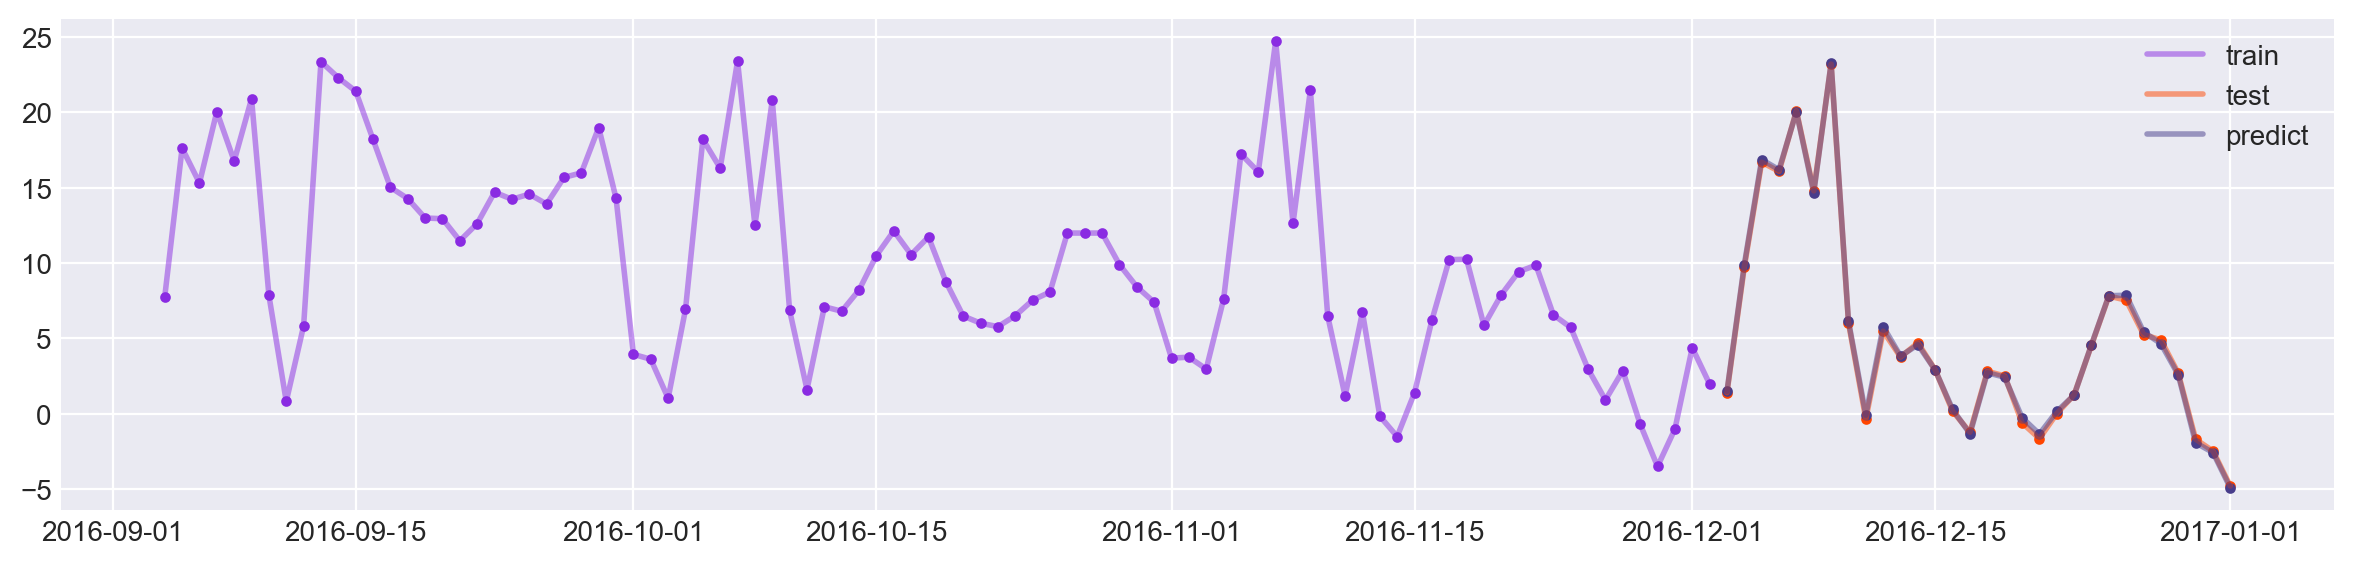

In [22]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [23]:
print(grid_search_results["params"])

{'l2_leaf_reg': 5}


In [24]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 20

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)


train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/20
200/200 [==============================] - 14s 52ms/step - loss: 7.5072 - mae: 1.7116 - val_loss: 1.4500 - val_mae: 0.9145
Epoch 2/20
200/200 [==============================] - 9s 43ms/step - loss: 0.9772 - mae: 0.7570 - val_loss: 0.1263 - val_mae: 0.2714
Epoch 3/20
200/200 [==============================] - 10s 51ms/step - loss: 0.6014 - mae: 0.5779 - val_loss: 1.3590 - val_mae: 0.9793
Epoch 4/20
200/200 [==============================] - 9s 45ms/step - loss: 0.4950 - mae: 0.5063 - val_loss: 0.2363 - val_mae: 0.4296
Epoch 5/20
200/200 [==============================] - 9s 45ms/step - loss: 0.4125 - mae: 0.4553 - val_loss: 0.1111 - val_mae: 0.2924
Epoch 6/20
200/200 [==============================] - 9s 46ms/step - loss: 0.3608 - mae: 0.4247 - val_loss: 0.0401 - val_mae: 0.1321
Epoch 7/20
200/200 [==============================] - 10s 49ms/step - loss: 0.3132 - mae: 0.3814 - val_loss: 0.4729 - val_mae: 0.5705
Epoch 8/20
200/200 [==============================] - 10s 50ms/ste

In [ ]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

In [ ]:
plot_tf_training_history(training_history)

In [ ]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [ ]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

In [ ]:
resultsDF.T

In [ ]:
plot_metrics(resultsDF)

In [ ]:
resultsDF_T = resultsDF.T.copy(deep=True)
resultsDF_T["Dataset"] = "Weather"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"

if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Weather"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Weather"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)